# Simulation Experiments

In [1]:
import sys
import time
import logging
import warnings
import numpy as np
import pandas as pd
import pprint as pp
import gpboost as gpb
import tensorflow as tf
import tensorflow_probability as tfp
import bokeh.plotting as bop
import bokeh.models as bom
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce   # https://contrib.scikit-learn.org/category_encoders/
import xgboost as xgb

from sklearn import set_config
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.utils import check_random_state
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from bokeh.io import output_notebook, export_svg
from bokeh.layouts import gridplot
from tensorflow.keras import models, layers, optimizers, metrics, losses
from tensorflow.random import set_seed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from category_encoders.wrapper import NestedCVWrapper
from simulate import make_sim, generate_data
from lmmnn.nn import reg_nn_lmm, calc_b_hat
from glmmnet import DistParams

sys.path.append("../")
from utils import (
    split, set_tf_loglevel,
    evaluate_model, evaluate_nn, evaluate_predictions, 
    plot_from_model, plot_from_predictions, plot_loss_curves, 
    embedding_preproc
)

In [2]:
# Package parameters
# Display of sklearn pipelines
set_config(display="diagram")

# Seaborn plotting style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Suppress tensorflow messages
set_tf_loglevel(logging.FATAL)

# Output bokeh plots to notebook
output_notebook()

# Shorthand for tfp.distributions
tfd = tfp.distributions

Loading BokehJS ...

## Experiment Set 1: Friedman1

### Experiment #1: Low Complexity, Gaussian response

In [3]:
# Configure simulation parameters
exp_id = 1                         # experiment id
n_train = 5000                     # number of training observations
n_val = 2500                       # number of validation observations
n_test = 2500                      # number of test observations
n = n_train + n_val + n_test       # total number of observations
n_categories = 100                 # number of categories for the categorical variable
f_structure = "friedman3"          # structure of the fixed effects f(X)
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

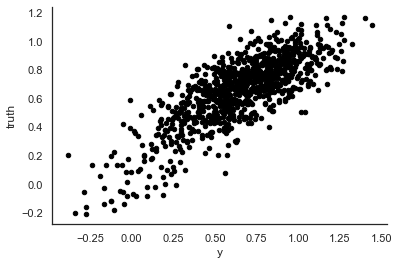

In [4]:
# Generate data
# Generate the fixed effects features X and f(X)
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
if (f_structure == "friedman1"):
    # Out of the n_features features, only 5 are actually used to compute y.
    # The remaining features are independent of y.
    X, f_X = make_friedman1(n_samples=n, n_features=10, noise=0.0, random_state=random_seed)
elif (f_structure == "friedman3"):
    X, f_X = make_friedman3(n_samples=n, noise=0.0, random_state=random_seed)

# Simulate random effects and therefore the response variable y
X, y, truth, Zu = make_sim(X, f_X, n_categories, sig2noise, y_dist, inverse_link, cat_dist, random_seed)

# Plot y truth (i.e. the conditional mean) against y observed
# The smaller the noise component, the closer the points follow a straight line
_ = pd.DataFrame({"y": y[:1000], "truth": truth[:1000]}).plot.scatter(x="y", y="truth", color="black")

In [5]:
# Split data into training (50%), val (25%), test (25%) set
X_train, X_dev, y_train, y_dev = split(X, y, n_train)
X_val, X_test, y_val, y_test = split(X_dev, y_dev, n_val)

# Conditional mean true values (unobservable in practice)
y_true_train = truth[:n_train]
y_true_val = truth[n_train:(n_train + n_val)]
y_true_test = truth[(n_train + n_val):]

In [6]:
X_train.shape, X_val.shape, X_test.shape

((5000, 5), (2500, 5), (2500, 5))

In [7]:
# Combine X, y, and truth into a dataframe and save to files
train_data = pd.concat([
    X_train.reset_index(drop=True), 
    pd.DataFrame(y_train, columns=["y"]), 
    pd.DataFrame(y_true_train, columns=["y_true"])], axis=1)
val_data = pd.concat([
    X_val.reset_index(drop=True),
    pd.DataFrame(y_val, columns=["y"]),
    pd.DataFrame(y_true_val, columns=["y_true"])], axis=1)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)

path = f"data/experiment_{exp_id}"
# train_data.to_csv(f"{path}/train_data.csv", index=False)
# val_data.to_csv(f"{path}/val_data.csv", index=False)
# test_data.to_csv(f"{path}/test_data.csv", index=False)

In [8]:
# Print summary statistics of the data
hicard_var = "category"
x_num = [col for col in X.columns if col not in hicard_var]
X[x_num].describe().transpose()

count        mean         std         min         25%         50%  \
X1  10000.0   49.961113   28.591906    0.011023   25.410206   50.129690   
X2  10000.0  936.713891  473.138516  125.742323  523.211644  934.995739   
X3  10000.0    0.499786    0.287384    0.000006    0.251716    0.500130   
X4  10000.0    6.015839    2.898262    1.000307    3.508183    6.021625   

            75%          max  
X1    74.009530    99.987144  
X2  1346.996879  1758.947798  
X3     0.749155     0.999925  
X4     8.523408    10.999010

In [9]:
pd.DataFrame(y).describe().transpose()

count      mean       std       min       25%     50%       75%     max
0  10000.0  0.664332  0.276497 -0.583982  0.496671  0.6816  0.854196  1.6167

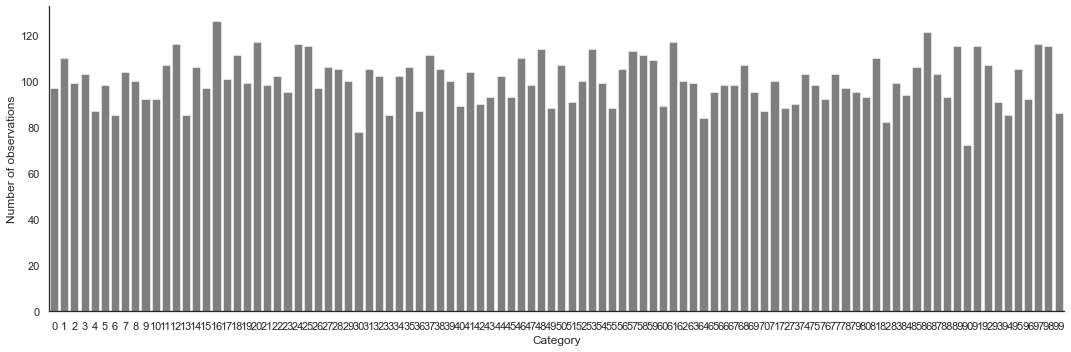

In [10]:
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

#### GLM

In [12]:
ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_ignore_cat = make_pipeline(ignore_cat_encoder, LinearRegression())
# Apply the pipeline to the dataframe for prediction
GLM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('linearregression', LinearRegression())])

In [13]:
train_scores = dict()
val_scores = dict()

print("> Training performance")
train_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_ignore_cat"])

print("-" * 80)
print("> Validation performance")
val_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GLM_ignore_cat"])

> Training performance
{'CRPS': 0.13958577815028708,
 'MAE': 0.19766618700119326,
 'R2': 0.20045826880515305,
 'RMSE': 0.2474713307232939,
 'RMSE_avg': 0.15214784419414626,
 'RMSE_avg_weighted': 0.1535417840702443}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.13711084082688468,
 'MAE': 0.19400286140487247,
 'R2': 0.1869474067070932,
 'RMSE': 0.24282234195370858,
 'RMSE_avg': 0.15438948643647496,
 'RMSE_avg_weighted': 0.15126260815256}


Observe that errors are quite large w.r.t. the distribution of the response variable. The model does not appear to overfit.

In [13]:
p = plot_from_model(GLM_ignore_cat, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [14]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_one_hot = make_pipeline(one_hot_encoder, LinearRegression())
GLM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('linearregression', LinearRegression())])

In [15]:
print("> Training performance")
train_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_one_hot"])

print("-" * 80)
print("> Validation performance")
val_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GLM_one_hot"])

> Training performance
{'CRPS': 0.10923372323601195,
 'MAE': 0.15387260021123114,
 'R2': 0.5084380078167584,
 'RMSE': 0.19404098626697935,
 'RMSE_avg': 4.4890664638556873e-07,
 'RMSE_avg_weighted': 4.301959996317257e-07}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.1100608028433544,
 'MAE': 0.15508620942640383,
 'R2': 0.47221889227467506,
 'RMSE': 0.19563936472061444,
 'RMSE_avg': 0.04698895178315655,
 'RMSE_avg_weighted': 0.046363392520496406}


In [16]:
p = plot_from_model(GLM_one_hot, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [16]:
# Apply a cross-validated version of GLMM encoding
# Docs: https://contrib.scikit-learn.org/category_encoders/
GLMM_encoder = make_column_transformer(
    # https://contrib.scikit-learn.org/category_encoders/wrapper.html
    (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_GLMM_enc = make_pipeline(GLMM_encoder, LinearRegression())
GLM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('linearregression', LinearRegression())])

In [18]:
# Check how the GLMMencoder works
# Docs: https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/wrapper.html#NestedCVWrapper.transform
# https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/glmm.html#GLMMEncoder
GLMM_encodings = pd.DataFrame({
    "category": X_train[hicard_var].values,
    "encoding": NestedCVWrapper(ce.GLMMEncoder(), cv=KFold(n_splits=5)).fit_transform(X_train["category"], y_train).values.ravel(),
})
GLMM_encodings

category  encoding
0          51  0.295890
1          92  0.084220
2          14 -0.033302
3          71  0.067341
4          60  0.115105
...       ...       ...
4995       48  0.131849
4996       57 -0.101698
4997       38 -0.036064
4998       79  0.111184
4999       96 -0.209800

[5000 rows x 2 columns]

In [19]:
# Different values for different folds (on the training set)
GLMM_encodings[GLMM_encodings["category"] == 51].value_counts()

category  encoding
51        0.172016    12
          0.295890    12
          0.237402     7
          0.202251     6
          0.233972     5
dtype: int64

In [17]:
# Plot GLMM encodings vs true random effects
p = bop.figure(x_axis_label="Ground truth", y_axis_label="GLMM encodings", width=400, height=300)
GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
p.circle(Zu[:n_train], GLMM_encodings.values.ravel(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

The linear shape of the plot above suggests that the GLMM encodings were able to capture the random effects very well - as one would expect given that the random effects signal is reasonably strong.

In [18]:
print("> Training performance")
train_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_GLMM_enc"])

print("-" * 80)
print("> Validation performance")
val_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GLM_GLMM_enc"])

> Training performance
{'CRPS': 0.10955892732124453,
 'MAE': 0.15431348485626464,
 'R2': 0.5056846522252765,
 'RMSE': 0.1945836622633357,
 'RMSE_avg': 0.014383650958200473,
 'RMSE_avg_weighted': 0.014468507564538687}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.10997612277273879,
 'MAE': 0.15492784300268903,
 'R2': 0.47304758441874617,
 'RMSE': 0.1954857134321738,
 'RMSE_avg': 0.04618606260637561,
 'RMSE_avg_weighted': 0.045551871720523565}


In [22]:
p = plot_from_model(GLM_GLMM_enc, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

We don't observe much improvement over the one-hot encoded model, most likely due to the restrictive structure of GLM in modelling the highly nonlinear relationship in `friedman1` data.

#### GBM

In [19]:
GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
GBM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metr...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [20]:
print("> Training performance")
train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ignore_cat"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_ignore_cat"])

> Training performance
{'CRPS': 0.12681681296660632,
 'MAE': 0.17994827771909971,
 'R2': 0.344713907724587,
 'RMSE': 0.22403702699075495,
 'RMSE_avg': 0.1468349726692077,
 'RMSE_avg_weighted': 0.14827347999797105}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.12772318620723988,
 'MAE': 0.18067149967324853,
 'R2': 0.29797156092708743,
 'RMSE': 0.22563510872784986,
 'RMSE_avg': 0.15342331088633346,
 'RMSE_avg_weighted': 0.15044502622937464}


Again, errors are quite large w.r.t. the distribution of the response variable.

In order to prevent overfitting, the default hyperparameters have been (manually) adjusted such that the training and validation results are comparable. No extensive/systematic hyperparameter search has been performed.

In [25]:
p = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [21]:
GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
GBM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_s...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [27]:
print("> Training performance")
train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_one_hot"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_one_hot"])

> Training performance
{'CRPS': 0.11977535215217767,
 'MAE': 0.17032877318440445,
 'R2': 0.5697888140611727,
 'RMSE': 0.21154105034394985,
 'RMSE_avg': 0.11104434336313969,
 'RMSE_avg_weighted': 0.11130829684092093}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.12382400050320862,
 'MAE': 0.17627096407829299,
 'R2': 0.5382086973027111,
 'RMSE': 0.2183964362629384,
 'RMSE_avg': 0.12127080766642521,
 'RMSE_avg_weighted': 0.11907573379839995}


In [28]:
p = plot_from_model(GBM_one_hot, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [22]:
# Apply a cross-validated version of GLMM encoding
GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
GBM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylev...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [23]:
print("> Training performance")
train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_GLMM_enc"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_GLMM_enc"])

> Training performance
{'CRPS': 0.0953707063135189,
 'MAE': 0.1352365145179635,
 'R2': 0.6277497206275865,
 'RMSE': 0.16885807802322852,
 'RMSE_avg': 0.021996511681853934,
 'RMSE_avg_weighted': 0.022131329325719824}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.09902311331623864,
 'MAE': 0.13982530128174808,
 'R2': 0.5754342290829398,
 'RMSE': 0.17546957034431115,
 'RMSE_avg': 0.04923779646531767,
 'RMSE_avg_weighted': 0.04881150819778606}


In [31]:
p = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [32]:
pd.DataFrame(val_scores).transpose()

MAE      RMSE        R2  RMSE_avg  RMSE_avg_weighted  \
GLM_ignore_cat  0.200727  0.251882  0.385746  0.157049           0.153402   
GLM_one_hot     0.164617  0.207343  0.583769  0.056346           0.055628   
GLM_GLMM_enc    0.165116  0.208315  0.579857  0.060343           0.059136   
GBM_ignore_cat  0.186020  0.231831  0.479648  0.154174           0.151231   
GBM_one_hot     0.176271  0.218396  0.538209  0.121271           0.119076   
GBM_GLMM_enc    0.148416  0.186689  0.662565  0.058290           0.057108   

                    CRPS  
GLM_ignore_cat  0.142099  
GLM_one_hot     0.116541  
GLM_GLMM_enc    0.116978  
GBM_ignore_cat  0.131076  
GBM_one_hot     0.123824  
GBM_GLMM_enc    0.105334

The high validation error with `GBM_one_hot` is likely due to the model overfitting to the large number of categories. Trees are known to be tricked by such variables.

The flatter shape (compared to the 45 degree line) in the predictions vs truth plot for GBM with GLMM encoding for both training and validation shows that the encoding does not cause much overfitting. The flatter shape means that there is still the effect of cross-subsidisation between the categories.

#### NN with Entity Embeddings

In [11]:
# Preprocess the data
ct_nn = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan, encoded_missing_value=-1), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = ct_nn.fit_transform(X_train)
X_val_ct = ct_nn.transform(X_val)
X_test_ct = ct_nn.transform(X_test)

# Convert to dataframes
colnames = [hicard_var] + x_num
X_train_ct = pd.DataFrame(X_train_ct, columns=colnames)
X_val_ct = pd.DataFrame(X_val_ct, columns=colnames)
X_test_ct = pd.DataFrame(X_test_ct, columns=colnames)

# Convert dataframe to lists to feed into Keras model
X_embed_train, X_embed_val, X_embed_test = embedding_preproc(X_train_ct, X_val_ct, X_test_ct, [hicard_var])

In [24]:
# Build a baseline neural network model with embeddings
# Code adapted from https://github.com/oegedijk/keras-embeddings/blob/72c1cfa29b1c57b5a14c24781f9dc713becb68ec/build_embeddings.py#L38

def build_baseline_nn(X_train, objective=nn_loss, print_embeddings=False, random_state=42, cat_vars=[hicard_var], num_vars=x_num):
  
    tf.random.set_seed(random_state)
    inputs = []
    embeddings = []

    for col in cat_vars:
        # Estimate cardinality on the training set
        cardinality = int(np.ceil(X_train[col].nunique()))
        # Set the embedding dimension
        embedding_dim = int(max(cardinality ** (1/4), 2))
        if print_embeddings:
            print(f'[{col}] cardinality: {cardinality} and embedding dim: {embedding_dim}')
        
        # Construct the embedding layer
        col_inputs = layers.Input(shape=(1, ), name=col+"_input")
        embedding = layers.Embedding(input_dim=cardinality, output_dim=embedding_dim, input_length=1, name=col+"_embed")(col_inputs)
        # Use SpatialDropout to prevent overfitting
        # See: https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
        embedding = layers.SpatialDropout1D(0.1, name=col+"dropout")(embedding)
        # Flatten out the embeddings
        embedding = layers.Reshape(target_shape=(embedding_dim,), name=col)(embedding)
        # Add the input shape to inputs
        inputs.append(col_inputs)
        # Add the embeddings to the embeddings layer
        embeddings.append(embedding)

    # Add numeric inputs
    num_inputs = layers.Input(shape=(len(num_vars),), name="numeric_inputs")
    inputs.append(num_inputs)

    # Paste all the inputs together
    x = layers.Concatenate(name="combined_inputs")(embeddings + [num_inputs])

    # Add some general NN layers
    hidden_units = [64, 32, 16]
    hidden_activation = "relu"
    output_activation = "linear"
    for hidden_layer in range(len(hidden_units)):
        units = hidden_units[hidden_layer]
        x = layers.Dense(units=units, activation=hidden_activation, name=f"hidden_{hidden_layer + 1}")(x)
    output = layers.Dense(units=1, activation=output_activation, name="output")(x)
    model = models.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer="adam", loss=objective, metrics=["mae"])

    return model

[category] cardinality: 100 and embedding dim: 3
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



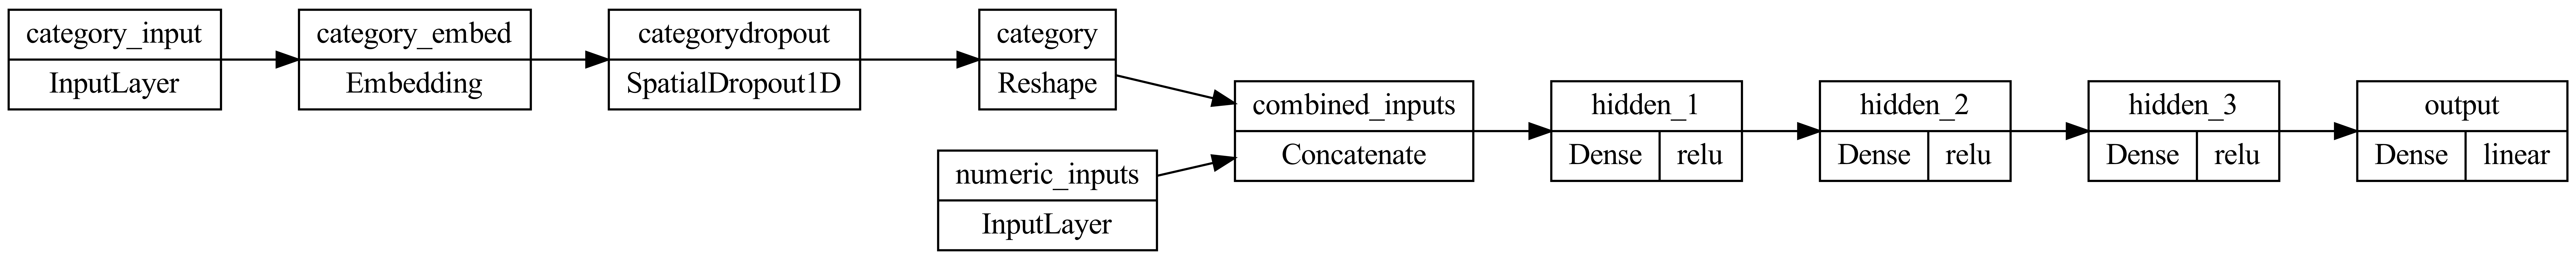

In [13]:
NN_ee = build_baseline_nn(X_train_ct, print_embeddings=True, random_state=random_seed)
plot_model(NN_ee, dpi=600, show_layer_activations=True, rankdir="LR")

In [14]:
NN_ee.count_params()

3821

In [25]:
# Use multi-GPU to speed up training
# Code adapted from: https://www.kdnuggets.com/2020/03/tensorflow-optimizing-training-time-performance.html
# Also referenced https://stackoverflow.com/questions/65322700/tensorflow-keras-consider-either-turning-off-auto-sharding-or-switching-the-a

# Define multi-GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy()
# Define training parameters
epochs = 500
patience = 10
# Update batch size value
batch_size = 128
batch_size *= mirrored_strategy.num_replicas_in_sync
# Create strategy scope to perform training
with mirrored_strategy.scope():
    NN_ee = build_baseline_nn(X_train_ct, random_state=random_seed)

es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)
checkpoint_filepath = f"models/experiment_{exp_id}/checkpoint"
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True)

# Wrap data in Dataset objects
train_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_train), X_train_ct[x_num]), y_train))
val_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_val), X_val_ct[x_num]), y_val))
test_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_test), X_test_ct[x_num]), y_test))

# The batch size must now be set on the Dataset objects
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)
test_data = test_data.batch(batch_size)

# Disable AutoShard
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)
test_data = test_data.with_options(options)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [26]:
hist = NN_ee.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[es, mc], verbose=0)
hist = hist.history
# Save model and history
# NN_ee.save(f"models/experiment_{exp_id}/NN_ee.h5")
# np.save(f"models/experiment_{exp_id}/NN_ee.npy", hist)

2022-10-14 12:41:56.202467: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Restoring model weights from the end of the best epoch: 29.
Epoch 39: early stopping


In [39]:
plot_loss_curves(hist)

Figure(id='2991', ...)

In [27]:
print("> Training performance")
train_scores["NN_ee"] = evaluate_nn(NN_ee, train_data, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["NN_ee"])

print("-" * 80)
print("> Validation performance")
val_scores["NN_ee"] = evaluate_nn(NN_ee, val_data, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["NN_ee"])

> Training performance
40/40 [==============================] - 0s 4ms/step
{'CRPS': 0.09509443754871429,
 'MAE': 0.13489346206188202,
 'R2': 0.630309685295285,
 'RMSE': 0.1682764771952617,
 'RMSE_avg': 0.016230199600973307,
 'RMSE_avg_weighted': 0.016148252325943527}
--------------------------------------------------------------------------------
> Validation performance
20/20 [==============================] - 0s 4ms/step
{'CRPS': 0.09847440835358136,
 'MAE': 0.13890285789966583,
 'R2': 0.5801955358556661,
 'RMSE': 0.1744829018510919,
 'RMSE_avg': 0.04651522320227225,
 'RMSE_avg_weighted': 0.04613488305178078}


In [41]:
p = plot_from_predictions(
    y_pred_train=NN_ee.predict(train_data).flatten(),
    y_train=y_true_train,
    y_pred_val=NN_ee.predict(val_data).flatten(),
    y_val=y_true_val,
    log_scale=log_plot,
)

20/20 [==============================] - 0s 5ms/step


In [28]:
# Extract embeddings from the fitted neural network model
embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
oe = ct_nn.named_transformers_["ordinalencoder"]
categories = oe.categories_[0]
embeddings = pd.concat([pd.DataFrame(categories, columns=["category"]), embeddings], axis=1)
embeddings

category  embedding_0  embedding_1  embedding_2
0         0     0.016357    -0.049176    -0.036258
1         1     0.102662     0.051235     0.156403
2         2    -0.111907    -0.039057    -0.088021
3         3    -0.026885     0.008785     0.069255
4         4     0.106624     0.031843     0.048883
..      ...          ...          ...          ...
95       95    -0.075753    -0.056643    -0.065699
96       96    -0.021175     0.053076     0.096313
97       97    -0.071311     0.072666    -0.038057
98       98     0.021387    -0.009384    -0.028346
99       99     0.161445     0.097471     0.053487

[100 rows x 4 columns]

#### GBM with Entity Embeddings

In [29]:
X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_val_ee = pd.merge(X_val_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1)

In [30]:
GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ee.fit(X_train_ee, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [31]:
print("> Training performance")
train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ee"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_ee"] = evaluate_model(GBM_ee, X_val_ee, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_ee"])

> Training performance
{'CRPS': 0.09519247785060092,
 'MAE': 0.13515167493744243,
 'R2': 0.629545261265412,
 'RMSE': 0.1684503442326716,
 'RMSE_avg': 0.015902367170762478,
 'RMSE_avg_weighted': 0.016012298219033584}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.09868444666888802,
 'MAE': 0.13940708425441925,
 'R2': 0.5788096799437985,
 'RMSE': 0.17477065526027855,
 'RMSE_avg': 0.0449702701366948,
 'RMSE_avg_weighted': 0.044609769043721374}


In [46]:
pd.DataFrame(val_scores).transpose()

MAE      RMSE        R2  RMSE_avg  RMSE_avg_weighted  \
GLM_ignore_cat  0.200727  0.251882  0.385746  0.157049           0.153402   
GLM_one_hot     0.164617  0.207343  0.583769  0.056346           0.055628   
GLM_GLMM_enc    0.165116  0.208315  0.579857  0.060343           0.059136   
GBM_ignore_cat  0.186020  0.231831  0.479648  0.154174           0.151231   
GBM_one_hot     0.176271  0.218396  0.538209  0.121271           0.119076   
GBM_GLMM_enc    0.148416  0.186689  0.662565  0.058290           0.057108   
NN_ee           0.146149  0.183920  0.672499  0.059347           0.058581   
GBM_ee          0.148053  0.186081  0.664759  0.054875           0.053876   

                    CRPS  
GLM_ignore_cat  0.142099  
GLM_one_hot     0.116541  
GLM_GLMM_enc    0.116978  
GBM_ignore_cat  0.131076  
GBM_one_hot     0.123824  
GBM_GLMM_enc    0.105334  
NN_ee           0.103497  
GBM_ee          0.105013

#### (Generalised) Linear Mixed Effects Models

In [47]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [48]:
y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
y_pred_val_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_val.csv").values.reshape(-1)
re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)

In [49]:
sigma_brms

array([0.2055149])

In [50]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["GLMM"] = evaluate_predictions(
    y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_brms, scale=sigma_brms,
)
pp.pprint(train_scores["GLMM"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLMM"] = evaluate_predictions(
    y_val, y_pred_val_brms, categories=X_val[hicard_var], likelihood=y_dist,
    loc=y_pred_val_brms, scale=sigma_brms,
)
pp.pprint(val_scores["GLMM"])

> Training performance
{'CRPS': 0.11466105582191066,
 'MAE': 0.16188584137111164,
 'R2': 0.6030307506323477,
 'RMSE': 0.2032039942177951,
 'RMSE_avg': 0.005506882383977646,
 'RMSE_avg_weighted': 0.0054381152931674125}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.11647595610002391,
 'MAE': 0.1645278199473371,
 'R2': 0.5844135965737309,
 'RMSE': 0.20718262821536998,
 'RMSE_avg': 0.05577125327859117,
 'RMSE_avg_weighted': 0.05498754579087156}


In [51]:
p = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_val_brms, y_true_val, log_scale=log_plot)

In [52]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
rev = np.array([float(re_brms[g]) for g in X_train[hicard_var]])
p.circle(Zu[:n_train], rev, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

The linear shape of the plot above suggests that the GLMM (here an LMM) were able to capture the random effects extremely well - better than the GLMM encodings which were computed based on an intercept model. Here the relationship between the predictors and the response is accurately captured.

Again, note that the line does not necessarily match with the `y = x` line as the `ground truth` numbers are from the raw simulated values of RE prior to normalisation (required to achieve the desired signal-to-noise).

#### GPBoost
Installation seemed to work but I kept getting errors from any attempt to call a function from the package. The temporary workaround therefore is to use the R package and read in the predictions.

In [53]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [54]:
y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
y_pred_val_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_val.csv").values.reshape(-1)
re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)

In [55]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["GPBoost"] = evaluate_predictions(
    y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(train_scores["GPBoost"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GPBoost"] = evaluate_predictions(
    y_val, y_pred_val_gpb, categories=X_val[hicard_var], likelihood=y_dist,
    loc=y_pred_val_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(val_scores["GPBoost"])

> Training performance
{'CRPS': 0.10730137271232518,
 'MAE': 0.15203548574299897,
 'R2': 0.6529626539823848,
 'RMSE': 0.18999488709851842,
 'RMSE_avg': 0.0047797629461310024,
 'RMSE_avg_weighted': 0.004715930278637692}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.11504420861471885,
 'MAE': 0.16207543735628027,
 'R2': 0.5974344332982249,
 'RMSE': 0.20391115530000326,
 'RMSE_avg': 0.055793167233200186,
 'RMSE_avg_weighted': 0.05412092329582721}


In [56]:
p = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_val_gpb, y_true_val, log_scale=log_plot)

In [57]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.circle(Zu[:n_train], re_gpb, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

We see a significant improvement in performance compared to the linear counterpart of GPBoost (i.e. plain GLMM). Again this shows a non-linear structure is required to model the non-linearity in the simulated data.

GPBoost, however, performs comparably with GBM with GLMM encoding, highlighting the benefit of using the latter (similar performance at a smaller computational cost). We do note that GBM with GLMM encoding tends to overfit a bit to the training data, and therefore may not generalise as well as GPBoost when exposed to data with a significant amount of noise or a shift in distribution.

#### LMMNN

In [32]:
# Parameters (adapted from LMMNN demo notebooks)
x_cols = [col for col in X_train_ct.columns if col not in [hicard_var]]
batch = 100
epochs = 500
patience = 10
qs = [n_categories]
q_spatial = None
n_neurons = [64, 32, 16]
dropout = None
activation = "relu"
Z_non_linear = False
Z_embed_dim_pct = 10
mode = "intercepts"
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
dist_matrix = None
time2measure_dict = None
spatial_embed_neurons = None
resultion = None
verbose = False
log_params = False
idx = None

In [33]:
# Fit model
X_train_ct[hicard_var] = X_train_ct[hicard_var].astype(int)
X_val_ct[hicard_var] = X_val_ct[hicard_var].astype(int)
tf.random.set_seed(random_seed)
_, y_pred_train, *_ = reg_nn_lmm(
    X_train_ct.rename(columns={hicard_var: "z0"}), X_train_ct.rename(columns={hicard_var: "z0"}), 
    y_train, y_train, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
    mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
    verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

tf.random.set_seed(random_seed)
lmmnn, y_pred_val, sigmas, rhos, weibull, hist_lmmnn = reg_nn_lmm(
    X_train_ct.rename(columns={hicard_var: "z0"}), X_val_ct.rename(columns={hicard_var: "z0"}), 
    y_train, y_val, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
    mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
    verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

79/79 [==============================] - 0s 2ms/step


In [60]:
print(sigmas) # --> (sigma2_e, sigma2_u, [])

(0.028292589, [0.022823967], [])


In [61]:
plot_loss_curves(hist_lmmnn)

Figure(id='5112', ...)

In [34]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["LMMNN"] = evaluate_predictions(
    y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train, scale=np.sqrt(sigmas[0]),
)
pp.pprint(train_scores["LMMNN"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["LMMNN"] = evaluate_predictions(
    y_val, y_pred_val, categories=X_val[hicard_var], likelihood=y_dist,
    loc=y_pred_val, scale=np.sqrt(sigmas[0]),
)
pp.pprint(val_scores["LMMNN"])

> Training performance
{'CRPS': 0.09374263115701086,
 'MAE': 0.13236352339617505,
 'R2': 0.6398219534884162,
 'RMSE': 0.16609744222429845,
 'RMSE_avg': 0.004130191291400525,
 'RMSE_avg_weighted': 0.004088138948757781}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.09726241884351547,
 'MAE': 0.13704780068051028,
 'R2': 0.5900229584044163,
 'RMSE': 0.17242851675592036,
 'RMSE_avg': 0.04331820900524118,
 'RMSE_avg_weighted': 0.04293134400123891}


In [63]:
p = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot)

In [35]:
sig2e_est, sig2b_ests, *_ = sigmas
u_hat = calc_b_hat(
    X_train_ct.rename(columns={hicard_var: "z0"}), y_train, y_pred_train, qs=[n_categories], q_spatial=None, 
    sig2e=sig2e_est, sig2bs=sig2b_ests, sig2bs_spatial=None,
    Z_non_linear=False, model=lmmnn, ls=None, mode=mode, rhos=None, 
    est_cors=est_cors, dist_matrix=None, weibull_ests=None)

In [36]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
re_lmmnn = np.array([float(u_hat[g]) for g in X_train_ct[hicard_var]])
p.circle(Zu[:n_train], re_lmmnn, color="#9f86c0")
bop.show(p)

#### LMMNet

In [37]:
# Reimplement LMMNN using tf-probability
from nbformat import convert
from glmmnet import DistParams
tf.random.set_seed(42)

# Construct a standard FFNN for the fixed effects
num_inputs = layers.Input(shape=(len(x_num),), name="numeric_inputs")
hidden_units = [64, 32, 16]
hidden_activation = "relu"
x = num_inputs
for hidden_layer in range(len(hidden_units)):
    units = hidden_units[hidden_layer]
    x = layers.Dense(units=units, activation=hidden_activation, name=f"hidden_{hidden_layer + 1}")(x)
f_X = layers.Dense(units=1, activation="linear", name="f_X")(x)

# Deal with categorical inputs (random effects)
cat_inputs = layers.Input(shape=(1,), name=f"category_inputs")
# Ordinal to one-hot encoded matrix
# Ref: https://keras.io/guides/preprocessing_layers/#encoding-integer-categorical-features-via-onehot-encoding
cardinality = int(np.ceil(X_train[hicard_var].nunique()))
one_hot = layers.CategoryEncoding(num_tokens=cardinality, output_mode="one_hot", name="OHE")(cat_inputs)
# Construct the random effects, by variational inference
# Code adapted from https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
# Specify the surrogate posterior over the random effects
def posterior_u(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus(1.)
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
          # CHANGE HERE - forcing a smaller scale parameter improves the result & eliminates training outliers
                     scale=0.01 * tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])
# Specify the prior over the random effects
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus()
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(1, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=tf.zeros(n), scale=tf.nn.softplus(c + t)),
          reinterpreted_batch_ndims=1)),
  ])
def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n), scale=0.1 * tf.ones(n)), 
        reinterpreted_batch_ndims=1
    )
RE = tfp.layers.DenseVariational(
    units=1, 
    make_posterior_fn=posterior_u,
    make_prior_fn=prior_trainable, # switching between the two doesn't really make a difference
    # make_prior_fn=prior_fixed,
    kl_weight=1 / X_train.shape[0], # https://github.com/tensorflow/probability/issues/396
                                    # https://github.com/tensorflow/probability/issues/691
    use_bias=False,
    name="RE",)(one_hot)

# Add the RE to the f(X) output
eta = layers.Add(name="f_X_plus_RE")([f_X, RE])
# Compute the distributional parameters
dist_params = DistParams(
    inverse_link="identity", 
    phi_init=0.1,
    name="dist_params",)(eta)
# Construct the distribution output
output = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :1], scale=t[..., 1:]), 
    name="distribution")(dist_params)
# targets = layers.Input(shape=(1,), name="targets")
lmmnet = models.Model(inputs=[num_inputs, cat_inputs], outputs=output)

def NLL(y_true, y_dist_pred):
    return -y_dist_pred.log_prob(y_true)

lmmnet.compile(optimizer="adam", loss=NLL)
es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
hist = lmmnet.fit(
    (X_train_ct[x_num], X_train_ct[hicard_var]), y_train, 
    validation_data=((X_val_ct[x_num], X_val_ct[hicard_var]), y_val),
    callbacks=[es],
    # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
    batch_size=256, epochs=500, verbose=False)

plot_loss_curves(hist.history)

Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


Figure(id='1217', ...)

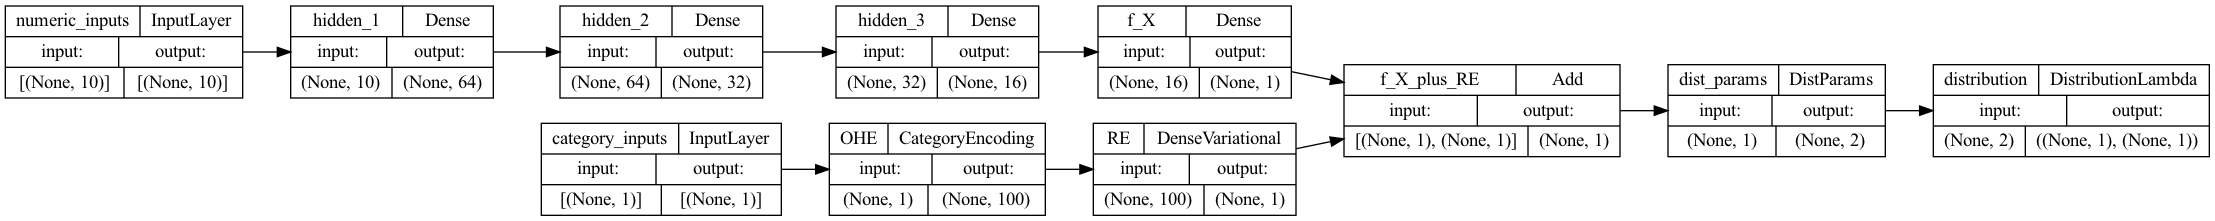

In [67]:
plot_model(lmmnet, rankdir="LR", show_shapes=True, show_layer_names=True)

In [38]:
# Examine the trained parameters
dummy_input = tf.constant(0.) # doesn't matter what this is
model_prior = lmmnet.get_layer("RE")._prior(dummy_input)
model_posterior = lmmnet.get_layer("RE")._posterior(dummy_input)

print("Prior mean:     ", model_prior.mean().numpy()[0])
print("Prior variance: ", model_prior.variance().numpy()[0])
print("Posterior mean: ")
print(model_posterior.mean().numpy())
print("Posterior variance: " )
print(model_posterior.variance().numpy())

# Get the dispersion parameter (here the error variance)
sigma_e = lmmnet.get_layer("dist_params").get_weights()
print(f"Estimated sigma_e: {sigma_e[0][0]:.8f}")

Prior mean:      0.0
Prior variance:  0.023743935
Posterior mean: 
[ 0.08077693 -0.32047826  0.21963227 -0.09405783 -0.20320377 -0.00050623
 -0.3087818  -0.18391766  0.04659935  0.10320327  0.03155816  0.03148779
 -0.0768576   0.01796088 -0.0529472  -0.25947815 -0.16567227  0.09678083
  0.27566367  0.10173506  0.25598648 -0.01205233  0.2509491   0.3029779
 -0.3118445   0.0419513   0.0656942  -0.03438977  0.07143518  0.0401551
 -0.09520563 -0.00865802  0.16601086 -0.03012147  0.09797867 -0.06000267
  0.062677   -0.19800988 -0.08850101 -0.06972203 -0.17823608 -0.088442
  0.07922066 -0.01921239  0.12077553 -0.080193    0.02643893 -0.14129673
  0.12873945  0.2204373   0.08241045  0.20521283 -0.01620221  0.13026926
 -0.00820144 -0.12223101  0.02985282 -0.15904067  0.3695886  -0.070003
  0.06096568  0.01948302 -0.18757461 -0.29117417  0.09250159  0.28374884
 -0.10092013 -0.25002158 -0.06428313 -0.14858793 -0.11422245  0.08621635
 -0.0392838  -0.10682504  0.07020696  0.10172462 -0.05191544 -0

In [39]:
# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 100
y_pred_train = np.zeros((X_train_ct.shape[0], n_prediction_samples))
y_pred_val = np.zeros((X_val_ct.shape[0], n_prediction_samples))
for i in range(n_prediction_samples):
    y_pred_train[:, i] = lmmnet((
        tf.convert_to_tensor(X_train_ct[x_num]), 
        tf.convert_to_tensor(X_train_ct[hicard_var]))).mean().numpy().flatten()
    y_pred_val[:, i] = lmmnet((
        tf.convert_to_tensor(X_val_ct[x_num]),
        tf.convert_to_tensor(X_val_ct[hicard_var]))).mean().numpy().flatten()
y_pred_train = y_pred_train.mean(axis=1)
y_pred_val = y_pred_val.mean(axis=1)

p = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot)

In [40]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["LMMNet"] = evaluate_predictions(
    y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train, scale=sigma_e[0][0]
)
pp.pprint(train_scores["LMMNet"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["LMMNet"] = evaluate_predictions(
    y_val, y_pred_val, categories=X_val[hicard_var], likelihood=y_dist,
    loc=y_pred_val, scale=sigma_e[0][0]
)
pp.pprint(val_scores["LMMNet"])

> Training performance
{'CRPS': 0.09367946354195267,
 'MAE': 0.13243309230558542,
 'R2': 0.6403776128192078,
 'RMSE': 0.1659692705906945,
 'RMSE_avg': 0.013855013939820098,
 'RMSE_avg_weighted': 0.013815140613332435}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.09708366343514394,
 'MAE': 0.13673355238859117,
 'R2': 0.5909150695662211,
 'RMSE': 0.172240812127258,
 'RMSE_avg': 0.04382870978570497,
 'RMSE_avg_weighted': 0.04327636633056152}


In [41]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: LMMNet", text_font_style="italic"), "above")
# Get the posterior mean of the random effects
u_hat = lmmnet.get_layer("RE").weights[0][:cardinality]
re_lmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy()
p.circle(Zu[:n_train], re_lmmnet, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

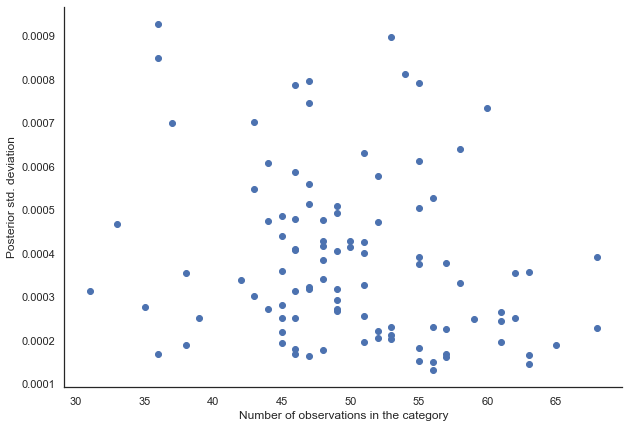

In [42]:
# Check variational uncertainty against number of training samples
# Code adapted from https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference
cat_counts = (X_train_ct.astype({hicard_var: "int"})
                .groupby(by=["category"], observed=True)
                .agg("size")
                .sort_values(ascending=False)
                .reset_index(name="count"))
fig, ax = plt.subplots(figsize=(10, 7))
_ = ax.plot(cat_counts["count"], model_posterior.variance().numpy()[cat_counts.category], "o")
_ = ax.set(
    ylabel="Posterior std. deviation",
    xlabel="Number of observations in the category",
)

#### Activity Regularisation

In [18]:
# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 100
y_pred_train = np.zeros((X_train_ct.shape[0], n_prediction_samples))
y_pred_val = np.zeros((X_val_ct.shape[0], n_prediction_samples))
for i in range(n_prediction_samples):
    y_pred_train[:, i] = lmmnet((
        tf.convert_to_tensor(X_train_ct[x_num]), 
        tf.convert_to_tensor(X_train_ct[hicard_var]))).mean().numpy().flatten()
    y_pred_val[:, i] = lmmnet((
        tf.convert_to_tensor(X_val_ct[x_num]),
        tf.convert_to_tensor(X_val_ct[hicard_var]))).mean().numpy().flatten()
y_pred_train = y_pred_train.mean(axis=1)
y_pred_val = y_pred_val.mean(axis=1)

p = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot)

In [19]:
tf.random.set_seed(42)

# Construct a standard FFNN for the fixed effects
num_inputs = layers.Input(shape=(len(x_num),), name="numeric_inputs")
hidden_units = [64, 32, 16]
hidden_activation = "relu"
x = num_inputs
for hidden_layer in range(len(hidden_units)):
    units = hidden_units[hidden_layer]
    x = layers.Dense(units=units, activation=hidden_activation, name=f"hidden_{hidden_layer + 1}")(x)
f_X = layers.Dense(units=1, activation="linear", name="f_X")(x)

# Deal with categorical inputs (random effects)
cat_inputs = layers.Input(shape=(1,), name=f"category_inputs")
# Ordinal to one-hot encoded matrix
# Ref: https://keras.io/guides/preprocessing_layers/#encoding-integer-categorical-features-via-onehot-encoding
cardinality = int(np.ceil(X_train[hicard_var].nunique()))
one_hot = layers.CategoryEncoding(num_tokens=cardinality, output_mode="one_hot", name="OHE")(cat_inputs)
# Construct the random effects, by variational inference
# Code adapted from https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
# Specify the surrogate posterior over the random effects
def posterior_u(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus(1.)
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
          # CHANGE HERE - forcing a smaller scale parameter improves the result & eliminates training outliers
                     scale=tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])
# Specify the prior over the random effects
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus()
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(1, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=tf.zeros(n), scale=tf.nn.softplus(c + t)),
          reinterpreted_batch_ndims=1)),
  ])
def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n), scale=0.1 * tf.ones(n)), 
        reinterpreted_batch_ndims=1
    )
RE = tfp.layers.DenseVariational(
    units=1, 
    make_posterior_fn=posterior_u,
    make_prior_fn=prior_trainable, # switching between the two doesn't really make a difference
    # make_prior_fn=prior_fixed,
    kl_weight=1 / X_train.shape[0], # https://github.com/tensorflow/probability/issues/396
                                    # https://github.com/tensorflow/probability/issues/691
    use_bias=False,
    name="RE",)(one_hot)

# Add the RE to the f(X) output
eta = layers.Add(name="f_X_plus_RE")([f_X, RE])
# Compute the distributional parameters
dist_params = DistParams(
    inverse_link="identity", 
    phi_init=0.1,
    name="dist_params",)(eta)
# Construct the distribution output
output = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :1], scale=t[..., 1:]), 
    name="distribution")(dist_params)
# targets = layers.Input(shape=(1,), name="targets")
lmmnet = models.Model(inputs=[num_inputs, cat_inputs], outputs=output)
lmmnet.add_loss(lambda: 100 * tf.reduce_sum(lmmnet.get_layer("RE")._posterior(0.).variance()))

def NLL(y_true, y_dist_pred):
    return -y_dist_pred.log_prob(y_true)

lmmnet.compile(optimizer="adam", loss=NLL)
es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
hist = lmmnet.fit(
    (X_train_ct[x_num], X_train_ct[hicard_var]), y_train, 
    validation_data=((X_val_ct[x_num], X_val_ct[hicard_var]), y_val),
    callbacks=[es],
    # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
    batch_size=256, epochs=500, verbose=False)

plot_loss_curves(hist.history)

Figure(id='1543', ...)

In [20]:
# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 100
y_pred_train = np.zeros((X_train_ct.shape[0], n_prediction_samples))
y_pred_val = np.zeros((X_val_ct.shape[0], n_prediction_samples))
for i in range(n_prediction_samples):
    y_pred_train[:, i] = lmmnet((
        tf.convert_to_tensor(X_train_ct[x_num]), 
        tf.convert_to_tensor(X_train_ct[hicard_var]))).mean().numpy().flatten()
    y_pred_val[:, i] = lmmnet((
        tf.convert_to_tensor(X_val_ct[x_num]),
        tf.convert_to_tensor(X_val_ct[hicard_var]))).mean().numpy().flatten()
y_pred_train = y_pred_train.mean(axis=1)
y_pred_val = y_pred_val.mean(axis=1)

p = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot)

In [17]:
# Examine the trained parameters
dummy_input = tf.constant(0.) # doesn't matter what this is
model_prior = lmmnet.get_layer("RE")._prior(dummy_input)
model_posterior = lmmnet.get_layer("RE")._posterior(dummy_input)

print("Prior mean:     ", model_prior.mean().numpy()[0])
print("Prior variance: ", model_prior.variance().numpy()[0])
print("Posterior mean: ")
print(model_posterior.mean().numpy())
print("Posterior variance: " )
print(model_posterior.variance().numpy())

# Get the dispersion parameter (here the error variance)
sigma_e = lmmnet.get_layer("dist_params").get_weights()
print(f"Estimated sigma_e: {sigma_e[0][0]:.8f}")

Prior mean:      0.0
Prior variance:  0.022115208
Posterior mean: 
[ 0.10944872 -0.3490818   0.229239   -0.13320619 -0.2234253  -0.00832462
 -0.28836244 -0.21577515  0.07020836  0.1086534  -0.02006323  0.00969362
 -0.0462032   0.08155231 -0.07416446 -0.25544187 -0.18569969  0.09088968
  0.26747325  0.16897835  0.23315439 -0.04576575  0.24255264  0.23852882
 -0.34871694  0.08727664  0.07579947 -0.03225493  0.11251452  0.04574718
 -0.08757452  0.01144486  0.12677777 -0.03556805  0.09466992 -0.08005413
  0.07793803 -0.22089213 -0.10140528 -0.09029221 -0.20071003 -0.08268985
  0.06043562 -0.05016694  0.13061528 -0.06745146  0.06020505 -0.15852697
  0.15603435  0.23007448  0.04804707  0.21241108 -0.00160161  0.15008263
 -0.01557472 -0.13880736  0.00789878 -0.12777425  0.3911555  -0.03814583
  0.03860036  0.00915316 -0.24069814 -0.31652132  0.08761775  0.282385
 -0.05784548 -0.2620665  -0.11672357 -0.1485107  -0.09351441  0.10867765
 -0.07298566 -0.03743397  0.08453687  0.07268224 -0.0524236

In [18]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: LMMNet", text_font_style="italic"), "above")
# Get the posterior mean of the random effects
u_hat = lmmnet.get_layer("RE").weights[0][:cardinality]
re_lmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy()
p.circle(Zu[:n_train], re_lmmnet, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### Comparison of Models for Experiment #1

In [43]:
with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.1977 0.2475 0.2005    0.1521             0.1535 0.1396
GLM_one_hot    0.1539 0.1940 0.5084    0.0000             0.0000 0.1092
GLM_GLMM_enc   0.1543 0.1946 0.5057    0.0144             0.0145 0.1096
GBM_ignore_cat 0.1799 0.2240 0.3447    0.1468             0.1483 0.1268
GBM_GLMM_enc   0.1352 0.1689 0.6277    0.0220             0.0221 0.0954
NN_ee          0.1349 0.1683 0.6303    0.0162             0.0161 0.0951
GBM_ee         0.1352 0.1685 0.6295    0.0159             0.0160 0.0952
LMMNN          0.1324 0.1661 0.6398    0.0041             0.0041 0.0937
LMMNet         0.1324 0.1660 0.6404    0.0139             0.0138 0.0937

Note that GLM one hot encoding produces 0 error `RMSE_avg` and `RMSE_avg_weighted`. This is a result of the balance property (for GLM with canonical links) ensuring that the sum of predictions must equal exactly to the sum of observed values (for any level of the categorical features).

In [44]:
with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(val_scores).transpose())

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.1940 0.2428 0.1869    0.1544             0.1513 0.1371
GLM_one_hot    0.1551 0.1956 0.4722    0.0470             0.0464 0.1101
GLM_GLMM_enc   0.1549 0.1955 0.4730    0.0462             0.0456 0.1100
GBM_ignore_cat 0.1807 0.2256 0.2980    0.1534             0.1504 0.1277
GBM_GLMM_enc   0.1398 0.1755 0.5754    0.0492             0.0488 0.0990
NN_ee          0.1389 0.1745 0.5802    0.0465             0.0461 0.0985
GBM_ee         0.1394 0.1748 0.5788    0.0450             0.0446 0.0987
LMMNN          0.1370 0.1724 0.5900    0.0433             0.0429 0.0973
LMMNet         0.1367 0.1722 0.5909    0.0438             0.0433 0.0971

Note that LMMNN outperforms `NN_ee` (though only by a small margin), suggesting that optimising the network via the (more suitable) mixed model likelihood can provide a benefit.

### Experiment #2

In [46]:
# Configure simulation parameters
exp_id = 2                         # experiment id
sig2noise = np.array([4, 1, 5])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

In [47]:
# Make a function to make life easier for repeated experiments
# Skip all the plotting and just return the table of results
def run_sim_experiment(exp_id, sim_data, y_dist="gaussian", random_state=random_seed):

    # Unpack data
    X_train, y_train, y_true_train = sim_data["train"]
    X_val, y_val, y_true_val = sim_data["val"]
    X_test, y_test, y_true_test = sim_data["test"]
    Zu = sim_data["Zu"]

    # Variable names
    hicard_var = "category"
    x_num = [col for col in X_train.columns if col not in hicard_var]
    colnames = [hicard_var] + x_num

    # Initialise
    train_scores = dict()
    val_scores = dict()
    plots = dict()
    runtimes = dict()

    # GLM
    # -------------------------------------------------------------------------
    ignore_cat_encoder = make_column_transformer(
        ("drop", [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ic = ignore_cat_encoder.fit_transform(X_train)
    X_val_ic = ignore_cat_encoder.transform(X_val)
    X_test_ic = ignore_cat_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_ignore_cat = LinearRegression()
        GLM_ignore_cat.fit(X_train_ic, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_ignore_cat = sm.GLM(y_train, X_train_ic, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_ignore_cat.scale
    end = time.time()
    train_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    val_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_val_ic, y_val, categories=X_val[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_ignore_cat"] = plot_from_model(GLM_ignore_cat, X_train_ic, y_true_train, X_val_ic, y_true_val, log_scale=log_plot, show=False)
    runtimes["GLM_ignore_cat"] = end - start

    one_hot_encoder = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ohe = one_hot_encoder.fit_transform(X_train)
    X_val_ohe = one_hot_encoder.transform(X_val)
    X_test_ohe = one_hot_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_one_hot = LinearRegression()
        GLM_one_hot.fit(X_train_ohe, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_one_hot = sm.GLM(y_train, X_train_ohe, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_one_hot.scale
    end = time.time()
    train_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    val_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_val_ohe, y_val, categories=X_val[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_one_hot"] = plot_from_model(GLM_one_hot, X_train_ohe, y_true_train, X_val_ohe, y_true_val, log_scale=log_plot, show=False)
    runtimes["GLM_one_hot"] = end - start

    GLMM_encoder = make_column_transformer(
        # https://contrib.scikit-learn.org/category_encoders/wrapper.html
        (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_GLMM_enc = GLMM_encoder.fit_transform(X_train, y_train)
    X_val_GLMM_enc = GLMM_encoder.transform(X_val)
    X_test_GLMM_enc = GLMM_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_GLMM_enc = LinearRegression()
        GLM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_GLMM_enc = sm.GLM(y_train, X_train_GLMM_enc, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_GLMM_enc.scale
    end = time.time()
    train_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    val_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_val_GLMM_enc, y_val, categories=X_val[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_GLMM_enc"] = plot_from_model(GLM_GLMM_enc, X_train_GLMM_enc, y_true_train, X_val_GLMM_enc, y_true_val, log_scale=log_plot, show=False)
    # Plot GLMM encodings vs true random effects
    p = bop.figure(title="GLMM Encodings", x_axis_label="Ground truth", y_axis_label="GLMM encodings", width=400, height=300)
    p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
    GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
    p.circle(Zu[:X_train.shape[0]], GLMM_encodings.values.ravel(), color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_encodings"] = p
    runtimes["GLM_GLMM_enc"] = end - start

    # GBM
    # -------------------------------------------------------------------------
    GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
    start = time.time()
    GBM_ignore_cat.fit(X_train, y_train)
    end = time.time()
    train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    val_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
    plots["GBM_ignore_cat"] = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot, show=False)
    runtimes["GBM_ignore_cat"] = end - start

    GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
    start = time.time()
    GBM_one_hot.fit(X_train, y_train)
    end = time.time()
    train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    val_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
    plots["GBM_one_hot"] = plot_from_model(GBM_one_hot, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot, show=False)
    runtimes["GBM_one_hot"] = end - start

    GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
    start = time.time()
    GBM_GLMM_enc.fit(X_train, y_train)
    end = time.time()
    train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    val_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
    plots["GBM_GLMM_enc"] = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot, show=False)
    runtimes["GBM_GLMM_enc"] = end - start

    # NN with entity embeddings
    # -------------------------------------------------------------------------
    ct_nn = make_column_transformer(
        (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan, encoded_missing_value=-1), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num),
    )
    X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
    X_val_ct = pd.DataFrame(ct_nn.transform(X_val), columns=colnames)
    X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
    X_embed_train, X_embed_val, X_embed_test = embedding_preproc(X_train_ct, X_val_ct, X_test_ct, [hicard_var])

    mirrored_strategy = tf.distribute.MirroredStrategy()
    # Define training parameters
    epochs = 500
    patience = 10
    # Update batch size value
    batch_size = 128
    batch_size *= mirrored_strategy.num_replicas_in_sync
    # Create strategy scope to perform training
    with mirrored_strategy.scope():
        NN_ee = build_baseline_nn(X_train_ct, objective=nn_loss, random_state=random_state)

    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)
    checkpoint_filepath = f"models/experiment_{exp_id}/checkpoint"
    mc = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True)

    # Wrap data in Dataset objects
    train_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_train), X_train_ct[x_num]), y_train))
    val_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_val), X_val_ct[x_num]), y_val))
    test_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_test), X_test_ct[x_num]), y_test))

    # The batch size must now be set on the Dataset objects
    train_data = train_data.batch(batch_size)
    val_data = val_data.batch(batch_size)
    test_data = test_data.batch(batch_size)

    # Disable AutoShard
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    train_data = train_data.with_options(options)
    val_data = val_data.with_options(options)
    test_data = test_data.with_options(options)

    start = time.time()
    hist = NN_ee.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[es, mc], verbose=0)
    end = time.time()
    hist = hist.history
    # Save model and history
    NN_ee.save(f"models/experiment_{exp_id}/NN_ee.h5")
    np.save(f"models/experiment_{exp_id}/NN_ee.npy", hist)
    train_scores["NN_ee"] = evaluate_model(
        NN_ee, train_data, y_train, categories=X_train[hicard_var], likelihood=y_dist
    )
    val_scores["NN_ee"] = evaluate_model(
        NN_ee, val_data, y_val, categories=X_val[hicard_var], likelihood=y_dist
    )
    plots["NN_ee"] = plot_from_predictions(
        y_pred_train=NN_ee.predict(train_data).flatten(),
        y_train=y_true_train,
        y_pred_val=NN_ee.predict(val_data).flatten(),
        y_val=y_true_val,
        log_scale=log_plot,
        show=False,
    )
    runtimes["NN_ee"] = end - start

    # Extract embeddings from the fitted neural network model
    embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
    embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
    oe = ct_nn.named_transformers_["ordinalencoder"]
    categories = oe.categories_[0]
    embeddings = pd.concat([pd.DataFrame(categories, columns=["category"]), embeddings], axis=1)

    # GBM with entity embeddings
    # -------------------------------------------------------------------------
    X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
    X_val_ee = pd.merge(X_val_ct, embeddings, on="category", how="left").drop("category", axis=1)
    X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1)
    GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_ee.fit(X_train_ee, y_train)
    end = time.time()
    train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    val_scores["GBM_ee"] = evaluate_model(GBM_ee, X_val_ee, y_val, categories=X_val[hicard_var], likelihood=y_dist)
    plots["GBM_ee"] = plot_from_model(GBM_ee, X_train_ee, y_true_train, X_val_ee, y_true_val, log_scale=log_plot, show=False)
    runtimes["GBM_ee"] = end - start

    # GLMM
    # -------------------------------------------------------------------------
    y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
    y_pred_val_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_val.csv").values.reshape(-1)
    re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
    sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)
    if y_dist == "gaussian":
        custom_params_train = {"loc": y_pred_train_brms, "scale": sigma_brms}
        custom_params_val = {"loc": y_pred_val_brms, "scale": sigma_brms}
    elif y_dist == "gamma":
        custom_params_train = {"shape": sigma_brms, "scale": y_pred_train_brms / sigma_brms}
        custom_params_val = {"shape": sigma_brms, "scale": y_pred_val_brms / sigma_brms}
    train_scores["GLMM"] = evaluate_predictions(
        y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
        **custom_params_train
    )
    val_scores["GLMM"] = evaluate_predictions(
        y_val, y_pred_val_brms, categories=X_val[hicard_var], likelihood=y_dist,
        **custom_params_val
    )
    plots["GLMM"] = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_val_brms, y_true_val, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
    p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
    rev = np.array([float(re_brms[g]) for g in X_train[hicard_var]])
    p.circle(Zu[:X_train.shape[0]], rev, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_RE_pred"] = p
    
    # GPBoost
    # -------------------------------------------------------------------------
    y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
    y_pred_val_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_val.csv").values.reshape(-1)
    re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
    scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)
    train_scores["GPBoost"] = evaluate_predictions(
        y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
    )
    val_scores["GPBoost"] = evaluate_predictions(
        y_val, y_pred_val_gpb, categories=X_val[hicard_var], likelihood=y_dist,
        loc=y_pred_val_gpb, scale=np.sqrt(scale_gpb),
    )
    plots["GPBoost"] = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_val_gpb, y_true_val, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
    p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
    p.circle(Zu[:X_train.shape[0]], re_gpb, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GPBoost_RE_pred"] = p

    # LMMNN
    # -------------------------------------------------------------------------
    # Inherit global parameters from the first experiment
    X_train_ct[hicard_var] = X_train_ct[hicard_var].astype(int)
    X_val_ct[hicard_var] = X_val_ct[hicard_var].astype(int)

    start = time.time()
    tf.random.set_seed(random_state)
    _, y_pred_train, *_ = reg_nn_lmm(
        X_train_ct.rename(columns={hicard_var: "z0"}), X_train_ct.rename(columns={hicard_var: "z0"}), 
        y_train, y_train, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
        mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
        verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
    end = time.time()

    tf.random.set_seed(random_state)
    lmmnn, y_pred_val, sigmas, rhos, weibull, hist_lmmnn = reg_nn_lmm(
        X_train_ct.rename(columns={hicard_var: "z0"}), X_val_ct.rename(columns={hicard_var: "z0"}), 
        y_train, y_val, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
        mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
        verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
    
    train_scores["LMMNN"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, scale=np.sqrt(sigmas[0]),
    )
    val_scores["LMMNN"] = evaluate_predictions(
        y_val, y_pred_val, categories=X_val[hicard_var], likelihood=y_dist,
        loc=y_pred_val, scale=np.sqrt(sigmas[0]),
    )
    plots["LMMNN"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot, show=False)
    # Plot the random effects
    sig2e_est, sig2b_ests, *_ = sigmas
    u_hat = calc_b_hat(
        X_train_ct.rename(columns={hicard_var: "z0"}), y_train, y_pred_train, qs=[n_categories], q_spatial=None, 
        sig2e=sig2e_est, sig2bs=sig2b_ests, sig2bs_spatial=None,
        Z_non_linear=False, model=lmmnn, ls=None, mode=mode, rhos=None, 
        est_cors=est_cors, dist_matrix=None, weibull_ests=None)
    re_lmmnn = np.array([float(u_hat[g]) for g in X_train_ct[hicard_var]])
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
    p.add_layout(bom.Title(text="Model: LMMNN", text_font_style="italic"), "above")
    p.circle(Zu[:X_train.shape[0]], re_lmmnn, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["LMMNN_RE_pred"] = p
    runtimes["LMMNN"] = end - start

    # GLMMNet (proposed model)
    # -------------------------------------------------------------------------
    tf.random.set_seed(random_state)
    # TODO: Write a function to construct the model
    # Construct a standard FFNN for the fixed effects
    num_inputs = layers.Input(shape=(len(x_num),), name="numeric_inputs")
    hidden_units = [64, 32, 16]
    hidden_activation = "relu"
    x = num_inputs
    for hidden_layer in range(len(hidden_units)):
        units = hidden_units[hidden_layer]
        x = layers.Dense(units=units, activation=hidden_activation, name=f"hidden_{hidden_layer + 1}")(x)
    f_X = layers.Dense(units=1, activation="linear", name="f_X")(x)

    # Deal with categorical inputs (random effects)
    cat_inputs = layers.Input(shape=(1,), name=f"category_inputs")
    # Ordinal to one-hot encoded matrix
    # Ref: https://keras.io/guides/preprocessing_layers/#encoding-integer-categorical-features-via-onehot-encoding
    cardinality = int(np.ceil(X_train[hicard_var].nunique()))
    one_hot = layers.CategoryEncoding(num_tokens=cardinality, output_mode="one_hot", name="OHE")(cat_inputs)
    # Construct the random effects, by variational inference
    # Code adapted from https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
    # Specify the surrogate posterior over the random effects
    def posterior_u(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.)) # Inverse of softplus(1.)
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer="random_normal"),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t[..., :n],
                # CHANGE HERE - forcing a smaller scale parameter improves the result & eliminates training outliers
                            scale=0.01 * tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
        ])
    # Specify the prior over the random effects
    def prior_trainable(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.)) # Inverse of softplus()
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(1, dtype=dtype, initializer="random_normal"),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=tf.zeros(n), scale=tf.nn.softplus(c + t)),
                reinterpreted_batch_ndims=1)),
        ])
    def prior_fixed(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        return lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n), scale=0.1 * tf.ones(n)), 
            reinterpreted_batch_ndims=1
        )
    RE = tfp.layers.DenseVariational(
        units=1, 
        make_posterior_fn=posterior_u,
        make_prior_fn=prior_trainable, # switching between the two doesn't really make a difference
        # make_prior_fn=prior_fixed,
        kl_weight=1 / X_train.shape[0], # https://github.com/tensorflow/probability/issues/396
                                        # https://github.com/tensorflow/probability/issues/691
        use_bias=False,
        name="RE",)(one_hot)

    # Add the RE to the f(X) output
    eta = layers.Add(name="f_X_plus_RE")([f_X, RE])

    if y_dist == "gaussian":
        # Compute the distributional parameters
        dist_params = DistParams(inverse_link="identity", phi_init=0.1, name="dist_params",)(eta)
        # Construct the distribution output
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :1], scale=t[..., 1:]), 
            name="distribution",
        )(dist_params)
    elif y_dist == "gamma":
        # Compute the distributional parameters
        dist_params = DistParams(
            inverse_link="exp", # <--- CHANGE FROM EXPERIMENTS 1-3
            phi_init=0.1,
            name="dist_params",)(eta)
        # Construct the distribution output
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Gamma(                    # https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Gamma
                concentration=1 / t[..., 1:],       # concentration = shape = 1 / dispersion
                rate=(1 / t[..., 1:]) / t[..., :1], # rate = shape / location
            ), name="distribution")(dist_params)
    
    glmmnet = models.Model(inputs=[num_inputs, cat_inputs], outputs=output)

    def NLL(y_true, y_dist_pred):
        return -y_dist_pred.log_prob(y_true)

    glmmnet.compile(optimizer="adam", loss=NLL)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    start = time.time()
    hist = glmmnet.fit(
        (X_train_ct[x_num], X_train_ct[hicard_var]), y_train, 
        validation_data=((X_val_ct[x_num], X_val_ct[hicard_var]), y_val),
        callbacks=[es],
        # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
        batch_size=256, epochs=500, verbose=False)
    end = time.time()

    # To make predictions, we call the model multiple times and average the results
    # This is because the random effects are sampled from the posterior (in the DenseVariational layer).
    n_prediction_samples = 100
    y_pred_train = np.zeros((X_train_ct.shape[0], n_prediction_samples))
    y_pred_val = np.zeros((X_val_ct.shape[0], n_prediction_samples))
    for i in range(n_prediction_samples):
        y_pred_train[:, i] = glmmnet((
            tf.convert_to_tensor(X_train_ct[x_num]), 
            tf.convert_to_tensor(X_train_ct[hicard_var]))).mean().numpy().flatten()
        y_pred_val[:, i] = glmmnet((
            tf.convert_to_tensor(X_val_ct[x_num]),
            tf.convert_to_tensor(X_val_ct[hicard_var]))).mean().numpy().flatten()
    y_pred_train = y_pred_train.mean(axis=1)
    y_pred_val = y_pred_val.mean(axis=1)

    sigma_e = glmmnet.get_layer("dist_params").get_weights()
    train_scores["GLMMNet"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, scale=sigma_e[0][0], gamma_shape=1 / sigma_e[0][0])
    val_scores["GLMMNet"] = evaluate_predictions(
        y_val, y_pred_val, categories=X_val[hicard_var], likelihood=y_dist,
        loc=y_pred_val, scale=sigma_e[0][0], gamma_shape=1 / sigma_e[0][0])
    plots["GLMMNet"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot, show=False)
    
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
    p.add_layout(bom.Title(text="Model: GLMMNet", text_font_style="italic"), "above")
    u_hat = glmmnet.get_layer("RE").weights[0][:cardinality]
    re_glmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy()
    p.circle(Zu[:n_train], re_glmmnet, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMMNet_RE_pred"] = p
    runtimes["GLMMNet"] = end - start
    
    return train_scores, val_scores, plots, runtimes

In [48]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, 
    n_train=n_train, n_val=n_val, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True
)

In [78]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [49]:
train_scores, val_scores, plots, runtimes = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist="gaussian", random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(val_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
79/79 [==============================] - 0s 2ms/step


UnboundLocalError: local variable 'output' referenced before assignment

**Observations**:
- More typical of what we see with real insurance data. Differences in performance are small.
- As often observed in practice with tabular data, GBM shows a marginal but consistent advantage over GLM and NN.
- Models with random effects (including GLMM encoded models) can capture the between-category differences better than the entity embeddings.

In [86]:
g = gridplot([
    plots["GBM_ee"], plots["NN_ee"], 
    plots["GBM_GLMM_enc"], plots["LMMNet"],
    ], ncols=1, height=400, width=200)
bop.show(g)

In [88]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"], plots["LMMNN_RE_pred"],
    plots["LMMNet_RE_pred"]
    ], ncols=3, height=300, width=300)
bop.show(g_re)

RE predictions are much worse compared to experiment #1 (as one would expect, the models would have picked up more random noise).

### Experiment #3

In [89]:
# Configure simulation parameters
exp_id = 3                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

In [90]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, 
    n_train=n_train, n_val=n_val, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [91]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


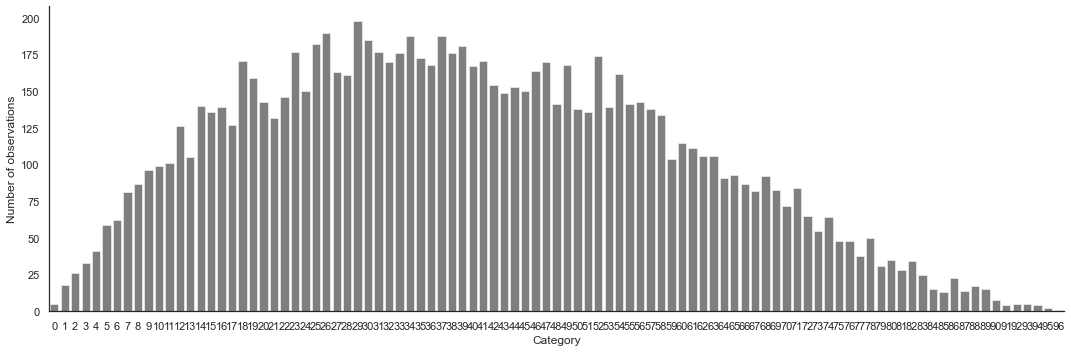

In [92]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_val = pd.read_csv(f"data/experiment_{exp_id}/val_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_val, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [94]:
train_scores, val_scores, plots, runtimes = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist="gaussian", random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(val_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 79.
Epoch 129: early stopping


MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.2084 0.2598 0.3563    0.1741             0.1683 0.1470
GLM_one_hot    0.1573 0.1978 0.6268    0.0000             0.0000 0.1114
GLM_GLMM_enc   0.1592 0.1997 0.6195    0.0445             0.0278 0.1126
GBM_ignore_cat 0.1859 0.2315 0.4889    0.1665             0.1605 0.1310
GBM_one_hot    0.1696 0.2100 0.5792    0.1302             0.1152 0.1192
GBM_GLMM_enc   0.1378 0.1721 0.7174    0.0501             0.0330 0.0972
NN_ee          0.1289 0.1612 0.7522    0.0165             0.0161 0.0910
GBM_ee         0.1364 0.1700 0.7244    0.0372             0.0279 0.0960
GLMM           0.1574 0.1979 0.6264    0.0236             0.0064 0.1115
GPBoost        0.1485 0.1860 0.6699    0.0344             0.0067 0.1049
LMMNN          0.1250 0.1558 0.7684    0.0200             0.0043 0.0881
LMMNet         0.1276 0.1591 0.7584    0.0172             0.0106 0.0900

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.2109 0.2647 0.3524    0.1815             0.1714 0.1494
GLM_one_hot    0.1653 0.2072 0.6031    0.0694             0.0474 0.1169
GLM_GLMM_enc   0.1673 0.2092 0.5957    0.0731             0.0550 0.1181
GBM_ignore_cat 0.1951 0.2444 0.4480    0.1798             0.1693 0.1380
GBM_one_hot    0.1786 0.2227 0.5415    0.1439             0.1243 0.1260
GBM_GLMM_enc   0.1507 0.1871 0.6766    0.0743             0.0561 0.1059
NN_ee          0.1443 0.1801 0.7001    0.0627             0.0411 0.1017
GBM_ee         0.1497 0.1860 0.6803    0.0722             0.0521 0.1053
GLMM           0.1654 0.2072 0.6033    0.0657             0.0466 0.1169
GPBoost        0.1631 0.2051 0.6113    0.0675             0.0466 0.1157
LMMNN          0.1410 0.1775 0.7090    0.0589             0.0382 0.1004
LMMNet         0.1421 0.1772 0.7099    0.0538             0.0374 0.1004

Runtime (sec)
GLM_ignore_cat         0.0341
GLM_one_hot            0.0210
GLM_GLMM_enc           3.2220
GBM_ignore_cat         0.6881
GBM_one_hot            0.3431
GBM_GLMM_enc           4.5767
NN_ee                 37.4442
GBM_ee                 0.6467
LMMNN                 12.0260
LMMNet                34.6575

**Observations**:
Results are mostly consistent with those from Experiment #1.
- NNs (`NN_ee`, `LMMNN`) are clear winners whenever signal in the data is strong enough.
- Followed by `GBM_ee`, `GPBoost` and `GBM_GLMM_enc`.
    - Embeddings are transferable & provide significant benefit when the NN from which they are extracted is good.
    - GLMM encoding can perform reasonably well even under skewed distributions. Better than plain GLMM, suggesting the non-linearity in GBM is more important than getting the random effects structure 100% correct.

In [96]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"], plots["LMMNN_RE_pred"],
    plots["LMMNet_RE_pred"]
    ], ncols=3, height=300, width=300)
bop.show(g_re)

Comparison of RE predictions
- RE predictions are better than those in Experiment #2, due to the stronger signal.
- Note the near-horizontal shape for LMMNN is mostly due to a few outlier predictions. Excluding the outliers, the model still does reasonably well in capturing the overall variation of the RE between categories.
- The scale of RE prediction by LMMNN does not look correct? (#TODO)

### Experiment #4

In [216]:
# Configure simulation parameters
exp_id = 4                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [217]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, 
    n_train=n_train, n_val=n_val, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True
)

# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_val, y_val, y_true_val = sim_data["val"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

# Variable names
hicard_var = "category"
x_num = [col for col in X_train.columns if col not in hicard_var]
colnames = [hicard_var] + x_num

# Initialise
train_scores = dict()
val_scores = dict()
plots = dict()
runtimes = dict()

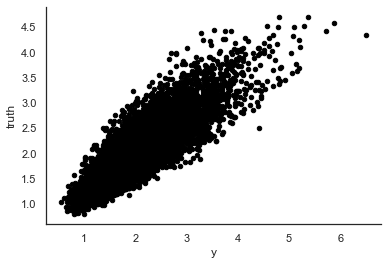

In [218]:
# Plot y truth (i.e. the conditional mean) against y observed
# The smaller the noise component, the closer the points follow a straight line
_ = pd.DataFrame({
    "y": np.concatenate([y_train, y_val, y_test]),
    "truth": np.concatenate([y_true_train, y_true_val, y_true_test]),
}).plot.scatter(x="y", y="truth", color="black")

#### GLM

In [219]:
ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_val_ic = ignore_cat_encoder.transform(X_val)
X_test_ic = ignore_cat_encoder.transform(X_test)

GLM_ignore_cat = sm.GLM(y_train, X_train_ic, family=sm.families.Gamma(sm.families.links.log())).fit()
print(GLM_ignore_cat.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4990
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                        0.068469
Method:                          IRLS   Log-Likelihood:                -3516.2
Date:                Tue, 11 Oct 2022   Deviance:                       333.41
Time:                        21:49:12   Pearson chi2:                     342.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.4408
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3289      0.012     27.191      0.0

In [220]:
# Evaluate model performance
gamma_shape = 1 / GLM_ignore_cat.scale
# Training set
print("> Training performance")
train_scores["GLM_ignore_cat"] = evaluate_model(
    GLM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], 
    likelihood=y_dist, gamma_shape=gamma_shape
)
pp.pprint(train_scores["GLM_ignore_cat"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLM_ignore_cat"] = evaluate_model(
    GLM_ignore_cat, X_val_ic, y_val, categories=X_val[hicard_var],
    likelihood=y_dist, gamma_shape=gamma_shape
)
pp.pprint(val_scores["GLM_ignore_cat"])

> Training performance
{'CRPS': 0.28915148173558475,
 'MAE': 0.408261647347078,
 'R2': 0.347097453777367,
 'RMSE': 0.5370080358508067,
 'RMSE_avg': 0.3330340208609986,
 'RMSE_avg_weighted': 0.33458865282782524}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.29564458654027803,
 'MAE': 0.41949737249533553,
 'R2': 0.30986154872158733,
 'RMSE': 0.5479853577105398,
 'RMSE_avg': 0.36077192710324835,
 'RMSE_avg_weighted': 0.3616474415244588}


In [276]:
p = plot_from_model(GLM_ignore_cat, X_train_ic, y_true_train, X_val_ic, y_true_val, log_scale=log_plot)

In [222]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_val_ohe = one_hot_encoder.transform(X_val)
X_test_ohe = one_hot_encoder.transform(X_test)

GLM_one_hot = sm.GLM(y_train, X_train_ohe, family=sm.families.Gamma(sm.families.links.log())).fit()
print(GLM_one_hot.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4891
Model Family:                   Gamma   Df Model:                          108
Link Function:                    log   Scale:                        0.040184
Method:                          IRLS   Log-Likelihood:                -2199.0
Date:                Tue, 11 Oct 2022   Deviance:                       197.83
Time:                        21:49:19   Pearson chi2:                     197.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.8108
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1256      0.036     -3.508      0.0

In [223]:
# Evaluate model performance
gamma_shape_glmohe = 1 / GLM_one_hot.scale

# Training set
print("> Training performance")
train_scores["GLM_one_hot"] = evaluate_model(
    GLM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var],
    likelihood=y_dist, gamma_shape=gamma_shape_glmohe
)
pp.pprint(train_scores["GLM_one_hot"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLM_one_hot"] = evaluate_model(
    GLM_one_hot, X_val_ohe, y_val, categories=X_val[hicard_var],
    likelihood=y_dist, gamma_shape=gamma_shape_glmohe
)
pp.pprint(val_scores["GLM_one_hot"])

> Training performance
{'CRPS': 0.2226941203750447,
 'MAE': 0.3147176703563337,
 'R2': 0.6113069877728536,
 'RMSE': 0.41434296548217886,
 'RMSE_avg': 0.01737109265055439,
 'RMSE_avg_weighted': 0.017540640025056203}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.22548370319086572,
 'MAE': 0.318735638857543,
 'R2': 0.5982299077677958,
 'RMSE': 0.41810912327166094,
 'RMSE_avg': 0.10346125163973023,
 'RMSE_avg_weighted': 0.10477531577851726}


In [224]:
p = plot_from_predictions(
    GLM_one_hot.predict(X_train_ohe), y_true_train,
    GLM_one_hot.predict(X_val_ohe), y_true_val,
    log_scale=log_plot)

In [225]:
# Apply a cross-validated version of GLMM encoding
# Docs: https://contrib.scikit-learn.org/category_encoders/
GLMM_encoder = make_column_transformer(
    # https://contrib.scikit-learn.org/category_encoders/wrapper.html
    (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_GLMM_enc = GLMM_encoder.fit_transform(X_train, y_train)
X_val_GLMM_enc = GLMM_encoder.transform(X_val)
X_test_GLMM_enc = GLMM_encoder.transform(X_test)

GLM_GLMM_enc = sm.GLM(y_train, X_train_GLMM_enc, family=sm.families.Gamma(sm.families.links.log())).fit()
print(GLM_GLMM_enc.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4989
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                        0.042126
Method:                          IRLS   Log-Likelihood:                -2363.0
Date:                Tue, 11 Oct 2022   Deviance:                       211.20
Time:                        21:49:32   Pearson chi2:                     210.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.7824
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4731      0.009     53.578      0.0

In [226]:
# Plot GLMM encodings vs true random effects
p = bop.figure(title="GLMM Encodings", x_axis_label="Ground truth", y_axis_label="GLMM encodings", width=400, height=300)
p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
p.circle(Zu[:n_train], GLMM_encodings.values.ravel(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

Note that the deviation from the $y=x$ line is due to that the GLMM encodings are based on a linear mixed model (i.e. assuming y ~ Gaussian) while in reality the RE are on the log scale of the response. This should be easily handled by the subsequent GLM (or other models) by applying a scaled coefficient to the encoded feature.

In [227]:
# Evaluate model performance
gamma_shape = 1 / GLM_GLMM_enc.scale

# Training set
print("> Training performance")
train_scores["GLM_GLMM_enc"] = evaluate_model(
    GLM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var],
    likelihood=y_dist, gamma_shape=gamma_shape
)
pp.pprint(train_scores["GLM_GLMM_enc"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLM_GLMM_enc"] = evaluate_model(
    GLM_GLMM_enc, X_val_GLMM_enc, y_val, categories=X_val[hicard_var],
    likelihood=y_dist, gamma_shape=gamma_shape
)
pp.pprint(val_scores["GLM_GLMM_enc"])

> Training performance
{'CRPS': 0.22987468570826863,
 'MAE': 0.3245293313645875,
 'R2': 0.5873090739271918,
 'RMSE': 0.4269421801608813,
 'RMSE_avg': 0.06155061712054972,
 'RMSE_avg_weighted': 0.06132045656800228}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.2302287718869978,
 'MAE': 0.32572191630063196,
 'R2': 0.5795572324999914,
 'RMSE': 0.4277148064898211,
 'RMSE_avg': 0.1345250288124408,
 'RMSE_avg_weighted': 0.1360378213112483}


In [228]:
p = plot_from_predictions(
    GLM_GLMM_enc.predict(X_train_GLMM_enc), y_true_train,
    GLM_GLMM_enc.predict(X_val_GLMM_enc), y_true_val,
    log_scale=log_plot)

#### GBM

In [229]:
GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
GBM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              ena...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=46, reg_alpha=0,
                              reg_lambda=1, ...))])

In [230]:
print("> Training performance")
train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ignore_cat"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_ignore_cat"])

> Training performance
{'CRPS': 0.30744046939036196,
 'MAE': 0.3674498234405975,
 'R2': 0.4737521627275184,
 'RMSE': 0.4821162450893754,
 'RMSE_avg': 0.3190127784828531,
 'RMSE_avg_weighted': 0.32073016284180567}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.3265042919964867,
 'MAE': 0.39616147754367914,
 'R2': 0.3932321284045921,
 'RMSE': 0.5138213313967205,
 'RMSE_avg': 0.3600840616154873,
 'RMSE_avg_weighted': 0.36155578991942555}


In [231]:
p = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [232]:
GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
GBM_one_hot.fit(X_train, y_train)

print("> Training performance")
train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_one_hot"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_one_hot"])

> Training performance
{'CRPS': 0.2806551479306672,
 'MAE': 0.3402467800144793,
 'R2': 0.563908961417455,
 'RMSE': 0.43887938791331643,
 'RMSE_avg': 0.22919633499991754,
 'RMSE_avg_weighted': 0.22905540683223619}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.29715011138940817,
 'MAE': 0.36067946512966065,
 'R2': 0.49954635201225894,
 'RMSE': 0.46664086814777944,
 'RMSE_avg': 0.2724262518674889,
 'RMSE_avg_weighted': 0.27284771251282064}


In [233]:
p = plot_from_model(GBM_one_hot, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

In [234]:
# Apply a cross-validated version of GLMM encoding
GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
GBM_GLMM_enc.fit(X_train, y_train)

print("> Training performance")
train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_GLMM_enc"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_val, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_GLMM_enc"])

> Training performance
{'CRPS': 0.23274987532803948,
 'MAE': 0.2797536713716608,
 'R2': 0.698584278086432,
 'RMSE': 0.36487117409739933,
 'RMSE_avg': 0.06643856430424422,
 'RMSE_avg_weighted': 0.06539206224501237}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.24667049267408678,
 'MAE': 0.2954865166099044,
 'R2': 0.6539325979117833,
 'RMSE': 0.3880441924655459,
 'RMSE_avg': 0.13213825197512366,
 'RMSE_avg_weighted': 0.13286693162725208}


In [235]:
p = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_val, y_true_val, log_scale=log_plot)

#### NN with Entity Embeddings

In [236]:
# Preprocess the data
ct_nn = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan, encoded_missing_value=-1), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = ct_nn.fit_transform(X_train)
X_val_ct = ct_nn.transform(X_val)
X_test_ct = ct_nn.transform(X_test)

# Convert to dataframes
colnames = [hicard_var] + x_num
X_train_ct = pd.DataFrame(X_train_ct, columns=colnames)
X_val_ct = pd.DataFrame(X_val_ct, columns=colnames)
X_test_ct = pd.DataFrame(X_test_ct, columns=colnames)

# Convert dataframe to lists to feed into Keras model
X_embed_train, X_embed_val, X_embed_test = embedding_preproc(X_train_ct, X_val_ct, X_test_ct, [hicard_var])

In [237]:
# Use multi-GPU to speed up training
# Code adapted from: https://www.kdnuggets.com/2020/03/tensorflow-optimizing-training-time-performance.html
# Also referenced https://stackoverflow.com/questions/65322700/tensorflow-keras-consider-either-turning-off-auto-sharding-or-switching-the-a

# Define multi-GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy()
# Define training parameters
epochs = 500
patience = 10
# Update batch size value
batch_size = 128
batch_size *= mirrored_strategy.num_replicas_in_sync
# Create strategy scope to perform training
with mirrored_strategy.scope():
    NN_ee = build_baseline_nn(X_train_ct, objective=nn_loss, random_state=random_seed)

es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)
checkpoint_filepath = f"models/experiment_{exp_id}/checkpoint"
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True)

# Wrap data in Dataset objects
train_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_train), X_train_ct[x_num]), y_train))
val_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_val), X_val_ct[x_num]), y_val))
test_data = tf.data.Dataset.from_tensor_slices(((tuple(X_embed_test), X_test_ct[x_num]), y_test))

# The batch size must now be set on the Dataset objects
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)
test_data = test_data.batch(batch_size)

# Disable AutoShard
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)
test_data = test_data.with_options(options)

In [238]:
hist = NN_ee.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[es, mc], verbose=0)
hist = hist.history
# Save model and history
NN_ee.save(f"models/experiment_{exp_id}/NN_ee.h5")
np.save(f"models/experiment_{exp_id}/NN_ee.npy", hist)

Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping


In [239]:
plot_loss_curves(hist)

Figure(id='45730', ...)

In [240]:
print("> Training performance")
train_scores["NN_ee"] = evaluate_model(
    NN_ee, train_data, y_train, categories=X_train[hicard_var], likelihood=y_dist
)
pp.pprint(train_scores["NN_ee"])

print("-" * 80)
print("> Validation performance")
val_scores["NN_ee"] = evaluate_model(
    NN_ee, val_data, y_val, categories=X_val[hicard_var], likelihood=y_dist
)
pp.pprint(val_scores["NN_ee"])

> Training performance
40/40 [==============================] - 2s 8ms/step
{'CRPS': 0.2191372495728545,
 'MAE': 0.26720025490776744,
 'R2': 0.7336524579282684,
 'RMSE': 0.34298959872087553,
 'RMSE_avg': 0.06993979770384305,
 'RMSE_avg_weighted': 0.0696584972024073}
--------------------------------------------------------------------------------
> Validation performance
20/20 [==============================] - 0s 5ms/step
{'CRPS': 0.24324957974575337,
 'MAE': 0.2976187608506842,
 'R2': 0.6631192455982551,
 'RMSE': 0.3828590718896372,
 'RMSE_avg': 0.12828349392049276,
 'RMSE_avg_weighted': 0.1310324082708678}


In [241]:
p = plot_from_predictions(
    y_pred_train=NN_ee.predict(train_data).flatten(),
    y_train=y_true_train,
    y_pred_val=NN_ee.predict(val_data).flatten(),
    y_val=y_true_val,
    log_scale=log_plot,
)

20/20 [==============================] - 0s 4ms/step


In [242]:
# Extract embeddings from the fitted neural network model
embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
oe = ct_nn.named_transformers_["ordinalencoder"]
categories = oe.categories_[0]
embeddings = pd.concat([pd.DataFrame(categories, columns=["category"]), embeddings], axis=1)
embeddings

category  embedding_0  embedding_1  embedding_2
0         0     0.024026     0.033649    -0.065832
1         1    -0.051872    -0.085014     0.135854
2         2     0.009230     0.069078     0.093159
3         3     0.196168    -0.194144    -0.145461
4         4    -0.116517     0.037550     0.109800
..      ...          ...          ...          ...
95       95     0.139517    -0.257554    -0.087333
96       96     0.033417    -0.092038     0.139880
97       97     0.009660    -0.044452     0.081439
98       98    -0.005270     0.031654     0.077938
99       99    -0.004072    -0.070954     0.023950

[100 rows x 4 columns]

#### GBM with Entity Embeddings

In [243]:
X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_val_ee = pd.merge(X_val_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1)

In [244]:
GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ee.fit(X_train_ee, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=46,
             reg_alpha=0, reg_lambda=1, ...)

In [245]:
print("> Training performance")
train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ee"])

print("-" * 80)
print("> Validation performance")
val_scores["GBM_ee"] = evaluate_model(GBM_ee, X_val_ee, y_val, categories=X_val[hicard_var], likelihood=y_dist)
pp.pprint(val_scores["GBM_ee"])

> Training performance
{'CRPS': 0.23170832295085994,
 'MAE': 0.2778299590639283,
 'R2': 0.7012489347002419,
 'RMSE': 0.3632547774262138,
 'RMSE_avg': 0.05878280298660073,
 'RMSE_avg_weighted': 0.05858514449612233}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.24623953323656306,
 'MAE': 0.2948372436481415,
 'R2': 0.6553544195620875,
 'RMSE': 0.38724623013983384,
 'RMSE_avg': 0.12416148025416719,
 'RMSE_avg_weighted': 0.12501098784389666}


#### (Generalised) Linear Mixed Effects Models

In [253]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [254]:
y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
y_pred_val_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_val.csv").values.reshape(-1)
re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)

In [255]:
print(sigma_brms)

[24.92924567]


In [256]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["GLMM"] = evaluate_predictions(
    y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
    shape=sigma_brms, scale=y_pred_train_brms / sigma_brms
)
pp.pprint(train_scores["GLMM"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLMM"] = evaluate_predictions(
    y_val, y_pred_val_brms, categories=X_val[hicard_var], likelihood=y_dist,
    shape=sigma_brms, scale=y_pred_val_brms / sigma_brms
)
pp.pprint(val_scores["GLMM"])

> Training performance
{'CRPS': 0.22269028211764152,
 'MAE': 0.31466346020668506,
 'R2': 0.6113141474421664,
 'RMSE': 0.41433914939572686,
 'RMSE_avg': 0.016839443312501378,
 'RMSE_avg_weighted': 0.016783196766620035}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.22590238547447908,
 'MAE': 0.31927146347224844,
 'R2': 0.596824636189032,
 'RMSE': 0.4188396953091608,
 'RMSE_avg': 0.10579443098582278,
 'RMSE_avg_weighted': 0.10679628548373278}


In [257]:
p = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_val_brms, y_true_val, log_scale=log_plot)

In [258]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
rev = np.array([float(re_brms[g]) for g in X_train[hicard_var]])
p.circle(Zu[:n_train], rev, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### GPBoost

In [259]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [260]:
y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
y_pred_val_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_val.csv").values.reshape(-1)
re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)

In [261]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["GPBoost"] = evaluate_predictions(
    y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
)
pp.pprint(train_scores["GPBoost"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GPBoost"] = evaluate_predictions(
    y_val, y_pred_val_gpb, categories=X_val[hicard_var], likelihood=y_dist,
)
pp.pprint(val_scores["GPBoost"])

> Training performance
{'CRPS': 0.28513525704713033,
 'MAE': 0.34181750959356716,
 'R2': 0.5481861464559082,
 'RMSE': 0.44672100639895446,
 'RMSE_avg': 0.2470627663640514,
 'RMSE_avg_weighted': 0.24732099813786482}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.29396107377931746,
 'MAE': 0.35335998388091794,
 'R2': 0.5090738186663628,
 'RMSE': 0.4621776485426901,
 'RMSE_avg': 0.27772084744497344,
 'RMSE_avg_weighted': 0.2788499430702469}


In [262]:
p = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_val_gpb, y_true_val, log_scale=log_plot)

In [263]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
p.circle(Zu[:n_train], re_gpb, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### GLMMNet

In [264]:
tf.random.set_seed(42)

# Construct a standard FFNN for the fixed effects
num_inputs = layers.Input(shape=(len(x_num),), name="numeric_inputs")
hidden_units = [64, 32, 16]
hidden_activation = "relu"
x = num_inputs
for hidden_layer in range(len(hidden_units)):
    units = hidden_units[hidden_layer]
    x = layers.Dense(units=units, activation=hidden_activation, name=f"hidden_{hidden_layer + 1}")(x)
f_X = layers.Dense(units=1, activation="linear", name="f_X")(x)

# Deal with categorical inputs (random effects)
cat_inputs = layers.Input(shape=(1,), name=f"category_inputs")
# Ordinal to one-hot encoded matrix
# Ref: https://keras.io/guides/preprocessing_layers/#encoding-integer-categorical-features-via-onehot-encoding
cardinality = int(np.ceil(X_train[hicard_var].nunique()))
one_hot = layers.CategoryEncoding(num_tokens=cardinality, output_mode="one_hot", name="OHE")(cat_inputs)
# Construct the random effects, by variational inference
# Code adapted from https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
# Specify the surrogate posterior over the random effects
def posterior_u(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus(1.)
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
          # CHANGE HERE - forcing a smaller scale parameter improves the result & eliminates training outliers
                     scale=0.01 * tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])
# Specify the prior over the random effects
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # Inverse of softplus()
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(1, dtype=dtype, initializer="random_normal"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=tf.zeros(n), scale=tf.nn.softplus(c + t)),
          reinterpreted_batch_ndims=1)),
  ])
def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n), scale=0.1 * tf.ones(n)), 
        reinterpreted_batch_ndims=1
    )
RE = tfp.layers.DenseVariational(
    units=1, 
    make_posterior_fn=posterior_u,
    make_prior_fn=prior_trainable, # switching between the two doesn't really make a difference
    # make_prior_fn=prior_fixed,
    kl_weight=1 / X_train.shape[0], # https://github.com/tensorflow/probability/issues/396
                                    # https://github.com/tensorflow/probability/issues/691
    use_bias=False,
    name="RE",)(one_hot)

# Add the RE to the f(X) output
eta = layers.Add(name="f_X_plus_RE")([f_X, RE])
# Compute the distributional parameters
dist_params = DistParams(
    inverse_link="exp", # <--- CHANGE FROM EXPERIMENTS 1-3
    phi_init=0.1,
    name="dist_params",)(eta)
# Construct the distribution output
output = tfp.layers.DistributionLambda(
    lambda t: tfd.Gamma(                    # https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Gamma
        concentration=1 / t[..., 1:],       # concentration = shape = 1 / dispersion
        rate=(1 / t[..., 1:]) / t[..., :1], # rate = shape / location
    ), name="distribution")(dist_params)
# targets = layers.Input(shape=(1,), name="targets")
glmmnet = models.Model(inputs=[num_inputs, cat_inputs], outputs=output)

def NLL(y_true, y_dist_pred):
    return -y_dist_pred.log_prob(y_true)

glmmnet.compile(optimizer="adam", loss=NLL)
es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
hist = glmmnet.fit(
    (X_train_ct[x_num], X_train_ct[hicard_var]), y_train, 
    validation_data=((X_val_ct[x_num], X_val_ct[hicard_var]), y_val),
    callbacks=[es],
    # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
    batch_size=256, epochs=500, verbose=False)

plot_loss_curves(hist.history)

Restoring model weights from the end of the best epoch: 82.
Epoch 132: early stopping


Figure(id='55894', ...)

In [265]:
# Examine the trained parameters
dummy_input = tf.constant(0.) # doesn't matter what this is
model_prior = glmmnet.get_layer("RE")._prior(dummy_input)
model_posterior = glmmnet.get_layer("RE")._posterior(dummy_input)

print("Prior mean:     ", model_prior.mean().numpy()[0])
print("Prior variance: ", model_prior.variance().numpy()[0])
print("Posterior mean: ")
print(model_posterior.mean().numpy())
print("Posterior variance: " )
print(model_posterior.variance().numpy())

# Get the dispersion parameter (here the error variance)
sigma_e = glmmnet.get_layer("dist_params").get_weights()
print(f"Estimated sigma_e: {sigma_e[0][0]:.8f}")

Prior mean:      0.0
Prior variance:  0.08119247
Posterior mean: 
[ 0.05190042 -0.1451557  -0.13761172  0.3209821  -0.28553173 -0.40204427
 -0.00552137  0.00565597 -0.10200974  0.18553454 -0.04216079  0.051553
  0.03363044  0.1336176   0.17019896 -0.16744648 -0.09046458  0.13525629
 -0.09852304 -0.1944769  -0.1169618  -0.16731302 -0.04809007  0.05245873
  0.0571377   0.15702696  0.00303821 -0.12112039  0.13072574 -0.21409397
 -0.10331612  0.31316268 -0.05532744 -0.00884895  0.11846896 -0.06488646
  0.01862879 -0.18463953  0.04434721 -0.01176899 -0.03568089  0.33485374
  0.13755493 -0.10925759 -0.15971781  0.23362145  0.11634038  0.18024427
  0.38149893 -0.04786948 -0.2413127  -0.18080601 -0.32014224 -0.01340813
 -0.12957901 -0.2144175  -0.07350782  0.1044419   0.04919589 -0.07037791
 -0.0078675  -0.13147481 -0.30707568 -0.12793778  0.08432389 -0.12420586
  0.27128777 -0.05191234 -0.40232933  0.01349266  0.20235741  0.09219883
 -0.15815565  0.20725495 -0.14198944 -0.29233122 -0.10465377

In [266]:
# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 100
y_pred_train = np.zeros((X_train_ct.shape[0], n_prediction_samples))
y_pred_val = np.zeros((X_val_ct.shape[0], n_prediction_samples))
for i in range(n_prediction_samples):
    y_pred_train[:, i] = glmmnet((
        tf.convert_to_tensor(X_train_ct[x_num]), 
        tf.convert_to_tensor(X_train_ct[hicard_var]))).mean().numpy().flatten()
    y_pred_val[:, i] = glmmnet((
        tf.convert_to_tensor(X_val_ct[x_num]),
        tf.convert_to_tensor(X_val_ct[hicard_var]))).mean().numpy().flatten()
y_pred_train = y_pred_train.mean(axis=1)
y_pred_val = y_pred_val.mean(axis=1)

p = plot_from_predictions(y_pred_train, y_true_train, y_pred_val, y_true_val, log_scale=log_plot)

In [267]:
# Evaluate model performance
# Training set
print("> Training performance")
train_scores["GLMMNet"] = evaluate_predictions(
    y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
    gamma_shape=1 / sigma_e[0][0]
)
pp.pprint(train_scores["GLMMNet"])

# Validation set
print("-" * 80)
print("> Validation performance")
val_scores["GLMMNet"] = evaluate_predictions(
    y_val, y_pred_val, categories=X_val[hicard_var], likelihood=y_dist,
    gamma_shape=1 / sigma_e[0][0]
)
pp.pprint(val_scores["GLMMNet"])

> Training performance
{'CRPS': 0.17955639058687656,
 'MAE': 0.2524599202851998,
 'R2': 0.7505259356784292,
 'RMSE': 0.33194742545002043,
 'RMSE_avg': 0.04417752429923561,
 'RMSE_avg_weighted': 0.04399132559279568}
--------------------------------------------------------------------------------
> Validation performance
{'CRPS': 0.19459450260901018,
 'MAE': 0.2757236195118603,
 'R2': 0.7061091402306386,
 'RMSE': 0.3575970121257904,
 'RMSE_avg': 0.0936446564094999,
 'RMSE_avg_weighted': 0.09281512099022203}


In [268]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMMNet", text_font_style="italic"), "above")
# Get the posterior mean of the random effects
u_hat = glmmnet.get_layer("RE").weights[0][:cardinality]
re_glmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy()
p.circle(Zu[:n_train], re_glmmnet, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### Comparison of Models for Experiment #4

In [271]:
with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(val_scores).transpose())

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.4083 0.5370 0.3471    0.3330             0.3346 0.2892
GLM_one_hot    0.3147 0.4143 0.6113    0.0174             0.0175 0.2227
GLM_GLMM_enc   0.3245 0.4269 0.5873    0.0616             0.0613 0.2299
GBM_ignore_cat 0.3674 0.4821 0.4738    0.3190             0.3207 0.3074
GBM_one_hot    0.3402 0.4389 0.5639    0.2292             0.2291 0.2807
GBM_GLMM_enc   0.2798 0.3649 0.6986    0.0664             0.0654 0.2327
NN_ee          0.2672 0.3430 0.7337    0.0699             0.0697 0.2191
GBM_ee         0.2778 0.3633 0.7012    0.0588             0.0586 0.2317
GLMM           0.3147 0.4143 0.6113    0.0168             0.0168 0.2227
GPBoost        0.3418 0.4467 0.5482    0.2471             0.2473 0.2851
GLMMNet        0.2525 0.3319 0.7505    0.0442             0.0440 0.1796

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.4195 0.5480 0.3099    0.3608             0.3616 0.2956
GLM_one_hot    0.3187 0.4181 0.5982    0.1035             0.1048 0.2255
GLM_GLMM_enc   0.3257 0.4277 0.5796    0.1345             0.1360 0.2302
GBM_ignore_cat 0.3962 0.5138 0.3932    0.3601             0.3616 0.3265
GBM_one_hot    0.3607 0.4666 0.4995    0.2724             0.2728 0.2972
GBM_GLMM_enc   0.2955 0.3880 0.6539    0.1321             0.1329 0.2467
NN_ee          0.2976 0.3829 0.6631    0.1283             0.1310 0.2432
GBM_ee         0.2948 0.3872 0.6554    0.1242             0.1250 0.2462
GLMM           0.3193 0.4188 0.5968    0.1058             0.1068 0.2259
GPBoost        0.3534 0.4622 0.5091    0.2777             0.2788 0.2940
GLMMNet        0.2757 0.3576 0.7061    0.0936             0.0928 0.1946

### Experiment #6

In [292]:
# Configure simulation parameters
exp_id = 6                         # experiment id
sig2noise = np.array([4, 1, 5])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [293]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, 
    n_train=n_train, n_val=n_val, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [281]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


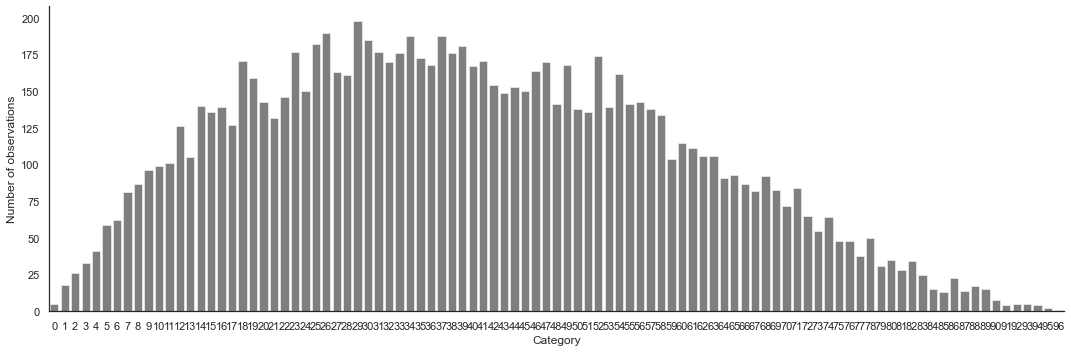

In [294]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_val = pd.read_csv(f"data/experiment_{exp_id}/val_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_val, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [295]:
train_scores, val_scores, plots, runtimes = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(val_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.6093 0.7860 0.0445    0.2968             0.1853 0.4257
GLM_one_hot    0.5935 0.7635 0.0984    0.0979             0.0219 0.4140
GLM_GLMM_enc   0.6047 0.7781 0.0636    0.2469             0.0912 0.4218
GBM_ignore_cat 0.5869 0.7572 0.1132    0.2769             0.1779 0.4331
GBM_one_hot    0.5851 0.7535 0.1219    0.2628             0.1372 0.4313
GBM_GLMM_enc   0.5771 0.7438 0.1444    0.2243             0.0915 0.4256
NN_ee          0.6022 0.7681 0.0876    0.2198             0.0827 0.4384
GBM_ee         0.5742 0.7385 0.1564    0.1993             0.0601 0.4229
GLMM           0.5962 0.7670 0.0902    0.2285             0.0724 0.4158
GPBoost        0.5987 0.7728 0.0763    0.2871             0.1747 0.4418
LMMNN          0.5662 0.7333 0.1683    0.2326             0.0579 0.4194
GLMMNet        0.5782 0.7487 0.1331    0.1916             0.0585 0.4059

MAE   RMSE     R2  RMSE_avg  RMSE_avg_weighted   CRPS
GLM_ignore_cat 0.6029 0.7914 0.0498    0.3386             0.2152 0.4214
GLM_one_hot    0.6003 0.7846 0.0658    0.4316             0.1915 0.4176
GLM_GLMM_enc   0.5972 0.7809 0.0746    0.3080             0.1747 0.4158
GBM_ignore_cat 0.6002 0.7899 0.0532    0.3505             0.2162 0.4440
GBM_one_hot    0.5976 0.7853 0.0642    0.3428             0.1988 0.4413
GBM_GLMM_enc   0.5950 0.7789 0.0794    0.3178             0.1718 0.4379
NN_ee          0.6110 0.7863 0.0620    0.2997             0.1836 0.4416
GBM_ee         0.5962 0.7785 0.0804    0.3001             0.1741 0.4375
GLMM           0.5969 0.7806 0.0755    0.3093             0.1738 0.4156
GPBoost        0.5982 0.7868 0.0607    0.3479             0.2132 0.4425
LMMNN          0.5999 0.7870 0.0601    0.3231             0.1709 0.4427
GLMMNet        0.5961 0.7841 0.0671    0.3011             0.1688 0.4176

Runtime (sec)
GLM_ignore_cat         0.2344
GLM_one_hot            6.6292
GLM_GLMM_enc           0.0354
GBM_ignore_cat         0.6235
GBM_one_hot            0.4017
GBM_GLMM_enc           9.6387
NN_ee                 10.1265
GBM_ee                 0.2862
LMMNN                 12.7782
GLMMNet               31.1520

In [298]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"], plots["LMMNN_RE_pred"],
    plots["GLMMNet_RE_pred"]
    ], ncols=3, height=300, width=300)
bop.show(g_re)